## Sites used (may be relevant later + too lazy to search through search history to re-find them)
1. https://cloud.google.com/docs/authentication/api-keys
2. https://console.cloud.google.com/apis/credentials/key/4dfe622f-1ab0-44c0-b98a-cb208b408768?project=song-popularity-project-441821&pli=1
3. https://console.cloud.google.com/apis/credentials?invt=Abhmkw&project=song-popularity-project-441821&supportedpurview=project&pli=1
4. https://console.cloud.google.com/apis/api/youtube.googleapis.com/metrics?project=song-popularity-project-441821&inv=1&invt=Abhmkw&pli=1
5. https://developer.spotify.com/documentation/web-api/concepts/apps
6. https://developer.spotify.com/dashboard/017b0364e66544b48a1397c34440e5a3/settings
7. https://huggingface.co/datasets/chloeliu/lyrics/viewer <--- link to raw dataset
8. https://raw.githubusercontent.com/kavinravi/MGSC310/refs/heads/main/songs_2019_with_popularity_and_streams%20(1).csv <--- link to dataset used

------------------------------------------------------------------------------

# Step 2 - Visualizing
keep all plots below here but above modeling

------------------------------------------------------------------------------

# Modeling of existing dataset w/ popularity and yt streams

In [ ]:
!pip install scikit-misc # this is needed for the method = loess in viz #1, not for anything else

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

%matplotlib inline

data = pd.read_csv('/content/songs_2019_with_popularity_and_streams.csv')
data.dropna(inplace = True)
data.reset_index(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     531 non-null    int64  
 1   Unnamed: 0                531 non-null    int64  
 2   artist_name               531 non-null    object 
 3   track_name                531 non-null    object 
 4   release_date              531 non-null    int64  
 5   genre                     531 non-null    object 
 6   lyrics                    531 non-null    object 
 7   len                       531 non-null    int64  
 8   dating                    531 non-null    float64
 9   violence                  531 non-null    float64
 10  world/life                531 non-null    float64
 11  night/time                531 non-null    float64
 12  shake the audience        531 non-null    float64
 13  family/gospel             531 non-null    float64
 14  romantic  

## Popularity score vs views on youtube

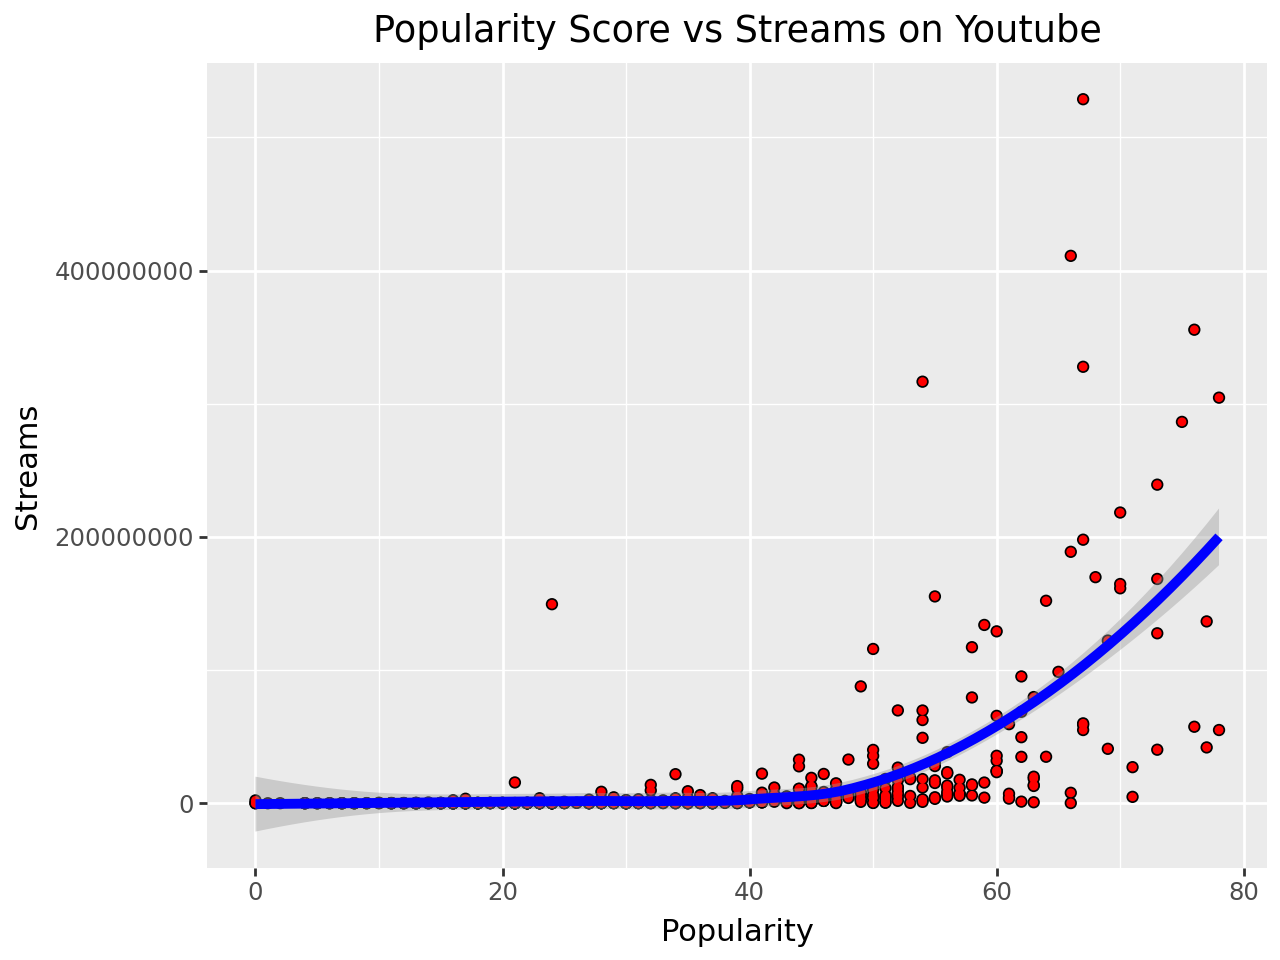

In [ ]:
(ggplot(data, aes(x = "popularity", y = "streams")) +
 geom_point(color = "black") +
 geom_point(color = "#FF0000", size = 0.8) +
 labs(x = "Popularity", y = "Streams", title = "Popularity Score vs Streams on Youtube") +
 geom_smooth(method = "loess", se = True, color = "blue", size = 2))

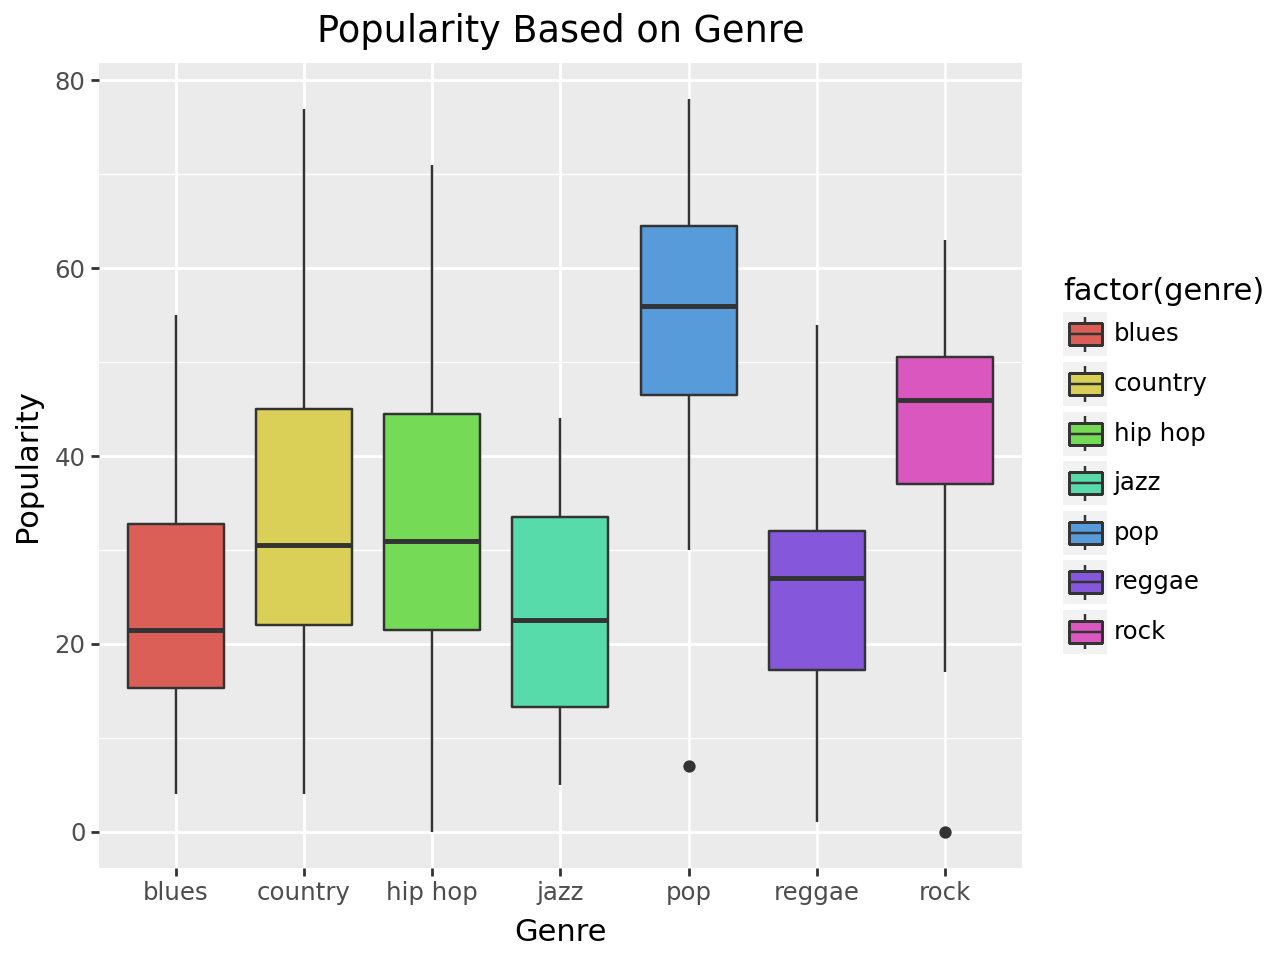

In [ ]:
(ggplot(data, aes(x= "factor(genre)", y = "popularity", fill="factor(genre)")) +
 geom_boxplot() +
 labs(title="Popularity Based on Genre", x="Genre", y="Popularity"))

------------------------------------------------------------------------------

# Step 3 - Modeling
keep all visualization above here and all modeling below here

------------------------------------------------------------------------------

## Beta Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import glm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/kavinravi/MGSC310/refs/heads/main/songs_2019_with_popularity_and_streams%20(1).csv') # this is just the github link for the same set as above
data.dropna(inplace = True)
data.reset_index(inplace = True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     531 non-null    int64  
 1   Unnamed: 0                531 non-null    int64  
 2   artist_name               531 non-null    object 
 3   track_name                531 non-null    object 
 4   release_date              531 non-null    int64  
 5   genre                     531 non-null    object 
 6   lyrics                    531 non-null    object 
 7   len                       531 non-null    int64  
 8   dating                    531 non-null    float64
 9   violence                  531 non-null    float64
 10  world/life                531 non-null    float64
 11  night/time                531 non-null    float64
 12  shake the audience        531 non-null    float64
 13  family/gospel             531 non-null    float64
 14  romantic  

In [ ]:
# Separate X and y
predictors = ["streams", "energy", "danceability"]
X = data[predictors]
y = data["popularity"]

# Rescale target variable (popularity) to (0, 1) range
scaler = MinMaxScaler(feature_range=(1e-6, 1 - 1e-6))  # Avoid exact 0 and 1
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=1234)

# Log-transform streams for better modeling
X_train["streams_log"] = X_train["streams"].apply(lambda x: np.log(x + 1))
X_test["streams_log"] = X_test["streams"].apply(lambda x: np.log(x + 1))

# Create and fit Beta Regression model
beta_model = glm(formula="y_train ~ streams_log", data=X_train, family=sm.families.Binomial())
beta_model_fit = beta_model.fit()
print(beta_model_fit.summary())

# Predict on Train and Test Sets
y_train_pred = beta_model_fit.predict(X_train)
y_test_pred = beta_model_fit.predict(X_test)

# Rescale Predictions Back to Original Scale (0–100)
y_train_pred_original = scaler.inverse_transform(y_train_pred.to_numpy().reshape(-1, 1)).flatten()
y_test_pred_original = scaler.inverse_transform(y_test_pred.to_numpy().reshape(-1, 1)).flatten()

y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


# Evaluate Metrics for Train Set
print("Train Set Metrics:")
print("MSE  : ", mean_squared_error(y_train_original, y_train_pred_original))
print("R2   : ", r2_score(y_train_original, y_train_pred_original))

# Evaluate Metrics for Test Set
print("\nTest Set Metrics:")
print("MSE  : ", mean_squared_error(y_test_original, y_test_pred_original))
print("R2   : ", r2_score(y_test_original, y_test_pred_original))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                y_train   No. Observations:                  424
Model:                            GLM   Df Residuals:                      422
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.94
Date:                Sat, 30 Nov 2024   Deviance:                       33.129
Time:                        23:10:54   Pearson chi2:                     32.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1348
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.2857      0.592     -7.245      

## ElasticNet


In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("songs_2019_with_popularity_and_streams.csv")

# Define features (X) and target (y)
X = data.drop(columns=["popularity", "artist_name", "track_name"])  # Adjust as needed
y = data["popularity"]  # Define the target variable

# Ensure X contains only numeric data
X = X.select_dtypes(include=["float64", "int64"])  # Drop non-numeric columns

# Handle missing values in both X and y
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaN with mean
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Drop rows with missing target values
valid_rows = ~y.isnull()
X = X[valid_rows]
y = y[valid_rows]

# Preprocessing: Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ElasticNet model with GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]}  # Adjusted grid
elastic_net = ElasticNet()
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='r2', error_score='raise')
grid_search.fit(X_train, y_train)

# Best parameters and performance evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Best Parameters: {'alpha': 1.0, 'l1_ratio': 0.8}
R2 Score: 0.20117376644274243
Mean Squared Error: 225.26662559553017


### PCA



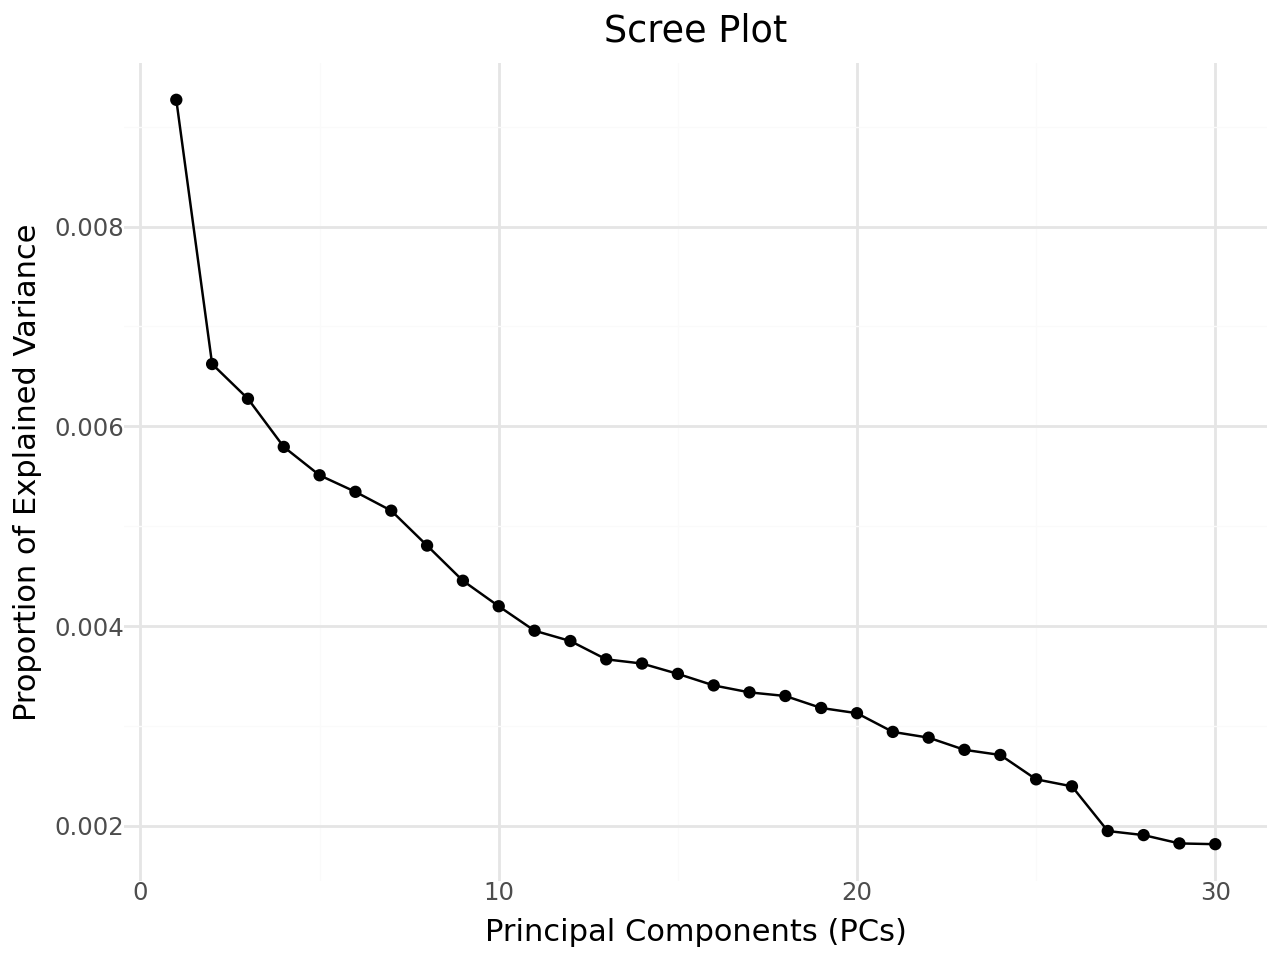


Linear Regression to Predict Popularity:
R2 Score: 0.2250
Mean Squared Error: 240.5054

Logistic Regression to Predict Hits:
Accuracy: 0.6355
ROC AUC: 0.6860

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        64
           1       0.55      0.56      0.55        43

    accuracy                           0.64       107
   macro avg       0.62      0.62      0.62       107
weighted avg       0.64      0.64      0.64       107



In [ ]:
# Import required libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, roc_auc_score
from plotnine import ggplot, aes, geom_line, geom_point, theme_minimal, labs

# Load the dataset
file_path = "https://raw.githubusercontent.com/kavinravi/MGSC310/refs/heads/main/songs_2019_with_popularity_and_streams%20(1).csv"
data = pd.read_csv(file_path)

# Define the binary target variable (hit or not) and continuous popularity target
data['is_hit'] = (data['streams'] > 1_000_000).astype(int)

# Drop rows with missing values across relevant columns
data = data.dropna(subset=["popularity", "streams", "is_hit"])

# Define features (X)
X = data.drop(columns=["is_hit", "streams", "popularity", "artist_name", "track_name"], errors="ignore")
X = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical variables

# Define targets
popularity = data['popularity']
is_hit = data['is_hit']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA-transformed features
pc_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pc_columns)

# Scree Plot
pcaDF = pd.DataFrame({
    "expl_var": pca.explained_variance_ratio_,
    "pc": range(1, len(pca.explained_variance_ratio_) + 1),
    "cum_var": pca.explained_variance_ratio_.cumsum()
})

# Create scree plot
scree_plot = (
    ggplot(pcaDF, aes(x="pc", y="expl_var")) +
    geom_line() +
    geom_point() +
    theme_minimal() +
    labs(x="Principal Components (PCs)", y="Proportion of Explained Variance", title="Scree Plot")
)
scree_plot.show()

# Linear Regression to Predict Popularity
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(
    X_pca_df.iloc[:, :10], popularity, test_size=0.2, random_state=1234
)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_pop, y_train_pop)
y_pred_pop = linear_regressor.predict(X_test_pop)

# Evaluate Linear Regression model
mse_pop = mean_squared_error(y_test_pop, y_pred_pop)
r2_pop = r2_score(y_test_pop, y_pred_pop)
print("\nLinear Regression to Predict Popularity:")
print(f"R2 Score: {r2_pop:.4f}")
print(f"Mean Squared Error: {mse_pop:.4f}\n")

# Logistic Regression to Predict Hits
X_train_hit, X_test_hit, y_train_hit, y_test_hit = train_test_split(
    X_pca_df.iloc[:, :10], is_hit, test_size=0.2, random_state=1234
)

logistic_regressor = LogisticRegression(random_state=1234, max_iter=1000)
logistic_regressor.fit(X_train_hit, y_train_hit)
y_pred_hit = logistic_regressor.predict(X_test_hit)
y_pred_prob_hit = logistic_regressor.predict_proba(X_test_hit)[:, 1]

# Evaluate Logistic Regression model
accuracy_hit = accuracy_score(y_test_hit, y_pred_hit)
roc_auc_hit = roc_auc_score(y_test_hit, y_pred_prob_hit)
print("Logistic Regression to Predict Hits:")
print(f"Accuracy: {accuracy_hit:.4f}")
print(f"ROC AUC: {roc_auc_hit:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_hit, y_pred_hit))


Clustering with Cleaned Data
*Note: After presentation, I cleaned up and reran the code to make it more readable, so some of the values are different from the ones shown on the presentation *italicized text*

In [ ]:
#Packages


from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal, scale_x_log10, scale_y_log10
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer


import os
from skimage import io
from skimage.transform import resize

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

np.random.seed(16)

In [ ]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/kavinravi/MGSC310/refs/heads/main/songs_2019_with_popularity_and_streams%20(1).csv'
data = pd.read_csv(file_path)

# Handle missing values
data.isnull().sum()

# Drop unnecessary columns
drop_columns = ["Unnamed: 0", "artist_name", "track_name", "release_date", "lyrics"]
data = data.drop(columns=drop_columns)

# Drop rows with missing values in the target column (popularity)
data = data.dropna(subset=["popularity"]).reset_index(drop=True)

# Define predictors
cont_predictors = ['len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience',
                   'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places',
                   'light/visual perceptions', 'family/spiritual', 'like/girls', 'sadness', 'feelings',
                   'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
                   'age', 'streams']  # Excluding target of popularity
cat_predictors = ['genre', 'topic']

# Scale continuous variables
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(data[cont_predictors])

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_encoded = encoder.fit_transform(data[cat_predictors])

# Concatenate continuous and categorical variables
X = np.concatenate([X_cont_scaled, X_cat_encoded], axis=1)

# Target variable (popularity)
y = data['popularity']

#New Dataframe
feature_names = cont_predictors + list(encoder.get_feature_names_out(cat_predictors))
X_df = pd.DataFrame(X, columns=feature_names)

# Final dataset (features X, target y)
clean_data = pd.concat([X_df, y], axis=1)

# Display the first few rows of the cleaned data
clean_data.head()

#NOTE: No Test-Train-Split because I am clustering

len    dating  violence  world/life  night/time  shake the audience  \
0  0.907301 -0.439396 -0.681355   -0.616692    2.833088            1.976249   
1  0.683448 -0.439065 -0.681286   -0.616612   -0.236843           -0.538558   
2  1.690787 -0.437545 -0.680969   -0.616243   -0.473214            0.825384   
3  0.526750 -0.433999 -0.313415   -0.615381    0.145271            0.006519   
4  2.026566 -0.438221  0.041811   -0.430901   -0.473474            2.704154   

   family/gospel  romantic  communication   obscene  ...  genre_reggae  \
0      -0.325983 -0.147004      -0.669012  0.028464  ...           0.0   
1      -0.325666  0.289862      -0.668891 -0.923710  ...           0.0   
2      -0.324205 -0.313657       4.049166  0.637250  ...           0.0   
3      -0.320798  1.461401      -0.667025  0.514667  ...           0.0   
4      -0.324854 -0.314048      -0.668580  1.492002  ...           0.0   

   genre_rock  topic_music  topic_night/time  topic_obscene  topic_romantic  \
0         0.0          0.0               1.0            0.0             0.0   
1         0.0          0.0               0.0            0.0             0.0   
2         0.0          0.0               0.0            1.0             0.0   
3         0.0          0.0               0.0            1.0             0.0   
4         0.0          0.0               0.0            1.0             0.0   

   topic_sadness  topic_violence  topic_world/life  popularity  
0            0.0             0.0               0.0        45.0  
1            1.0             0.0               0.0        56.0  
2            0.0             0.0               0.0        47.0  
3            0.0             0.0               0.0        62.0  
4            0.0             0.0               0.0        56.0  

[5 rows x 39 columns]

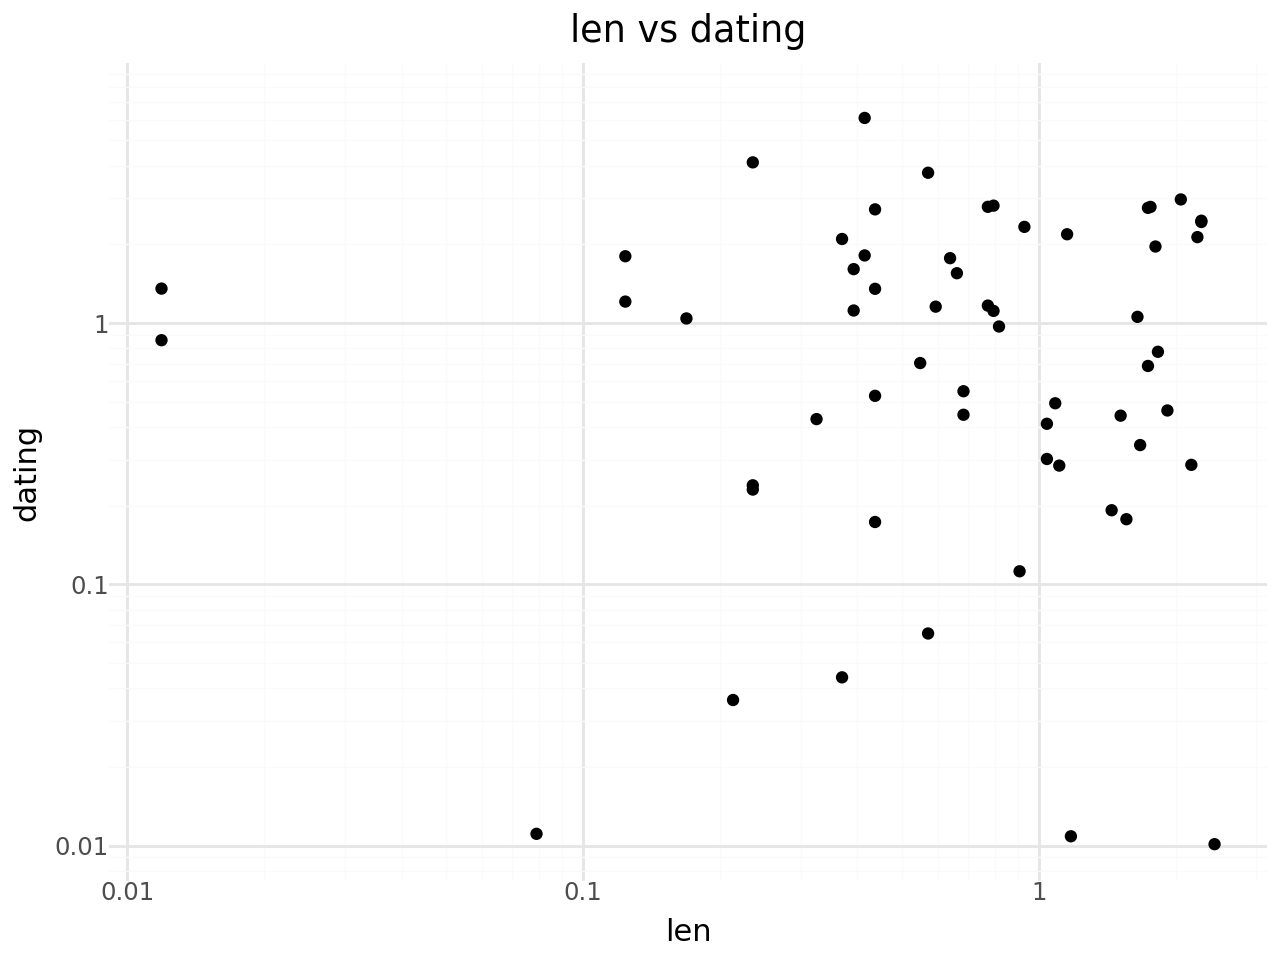

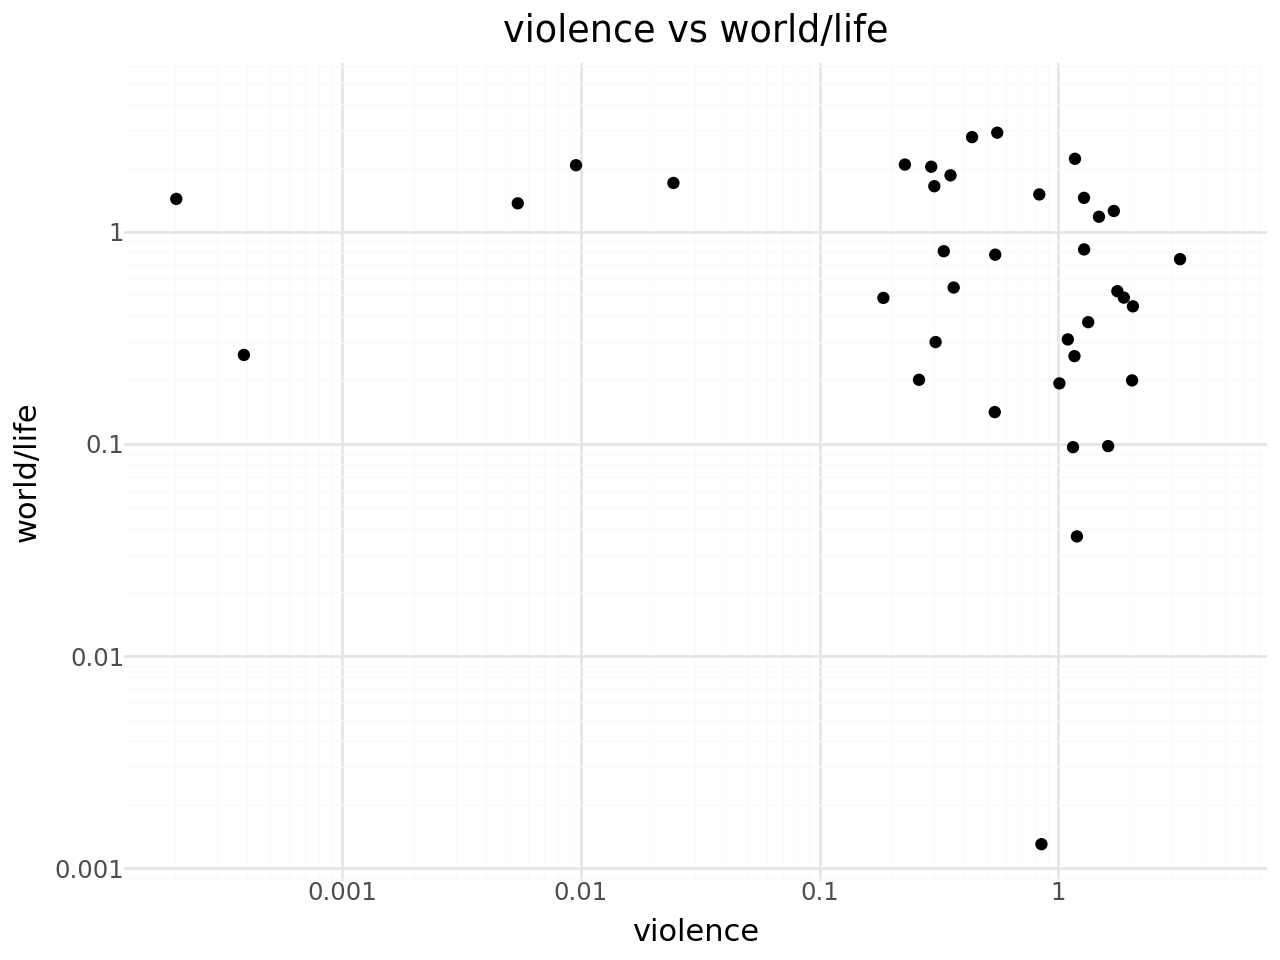

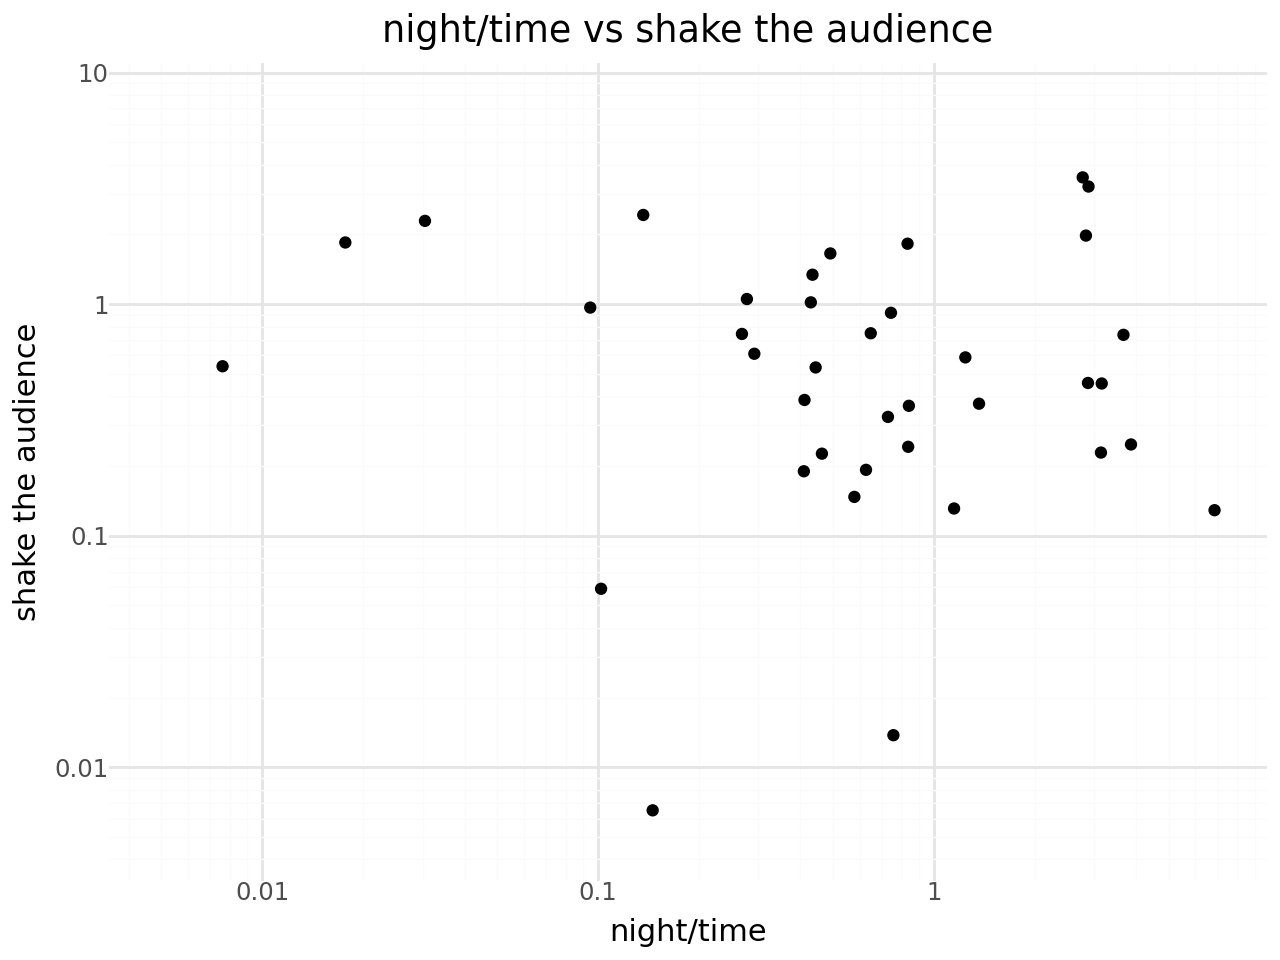

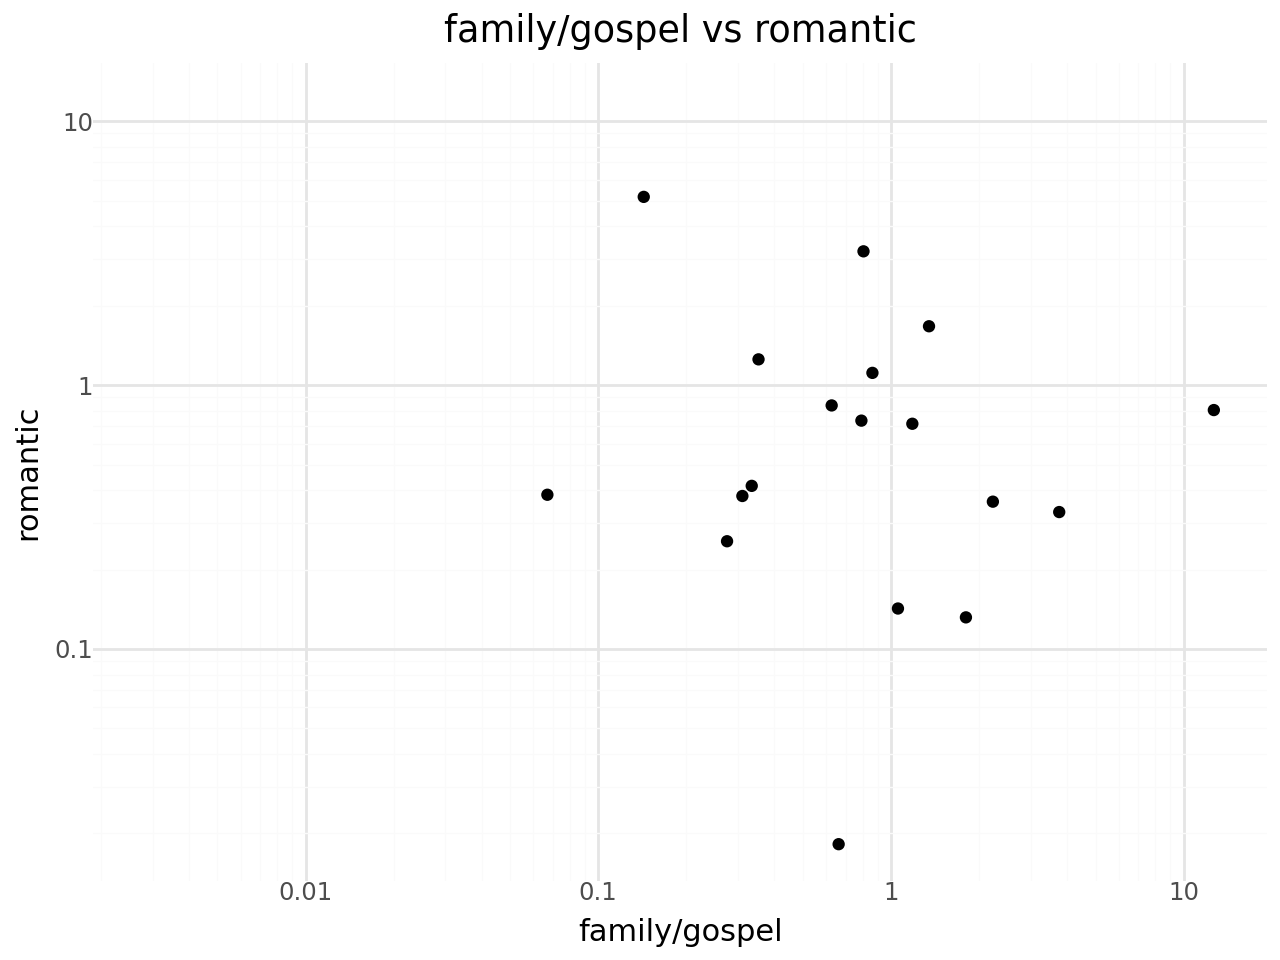

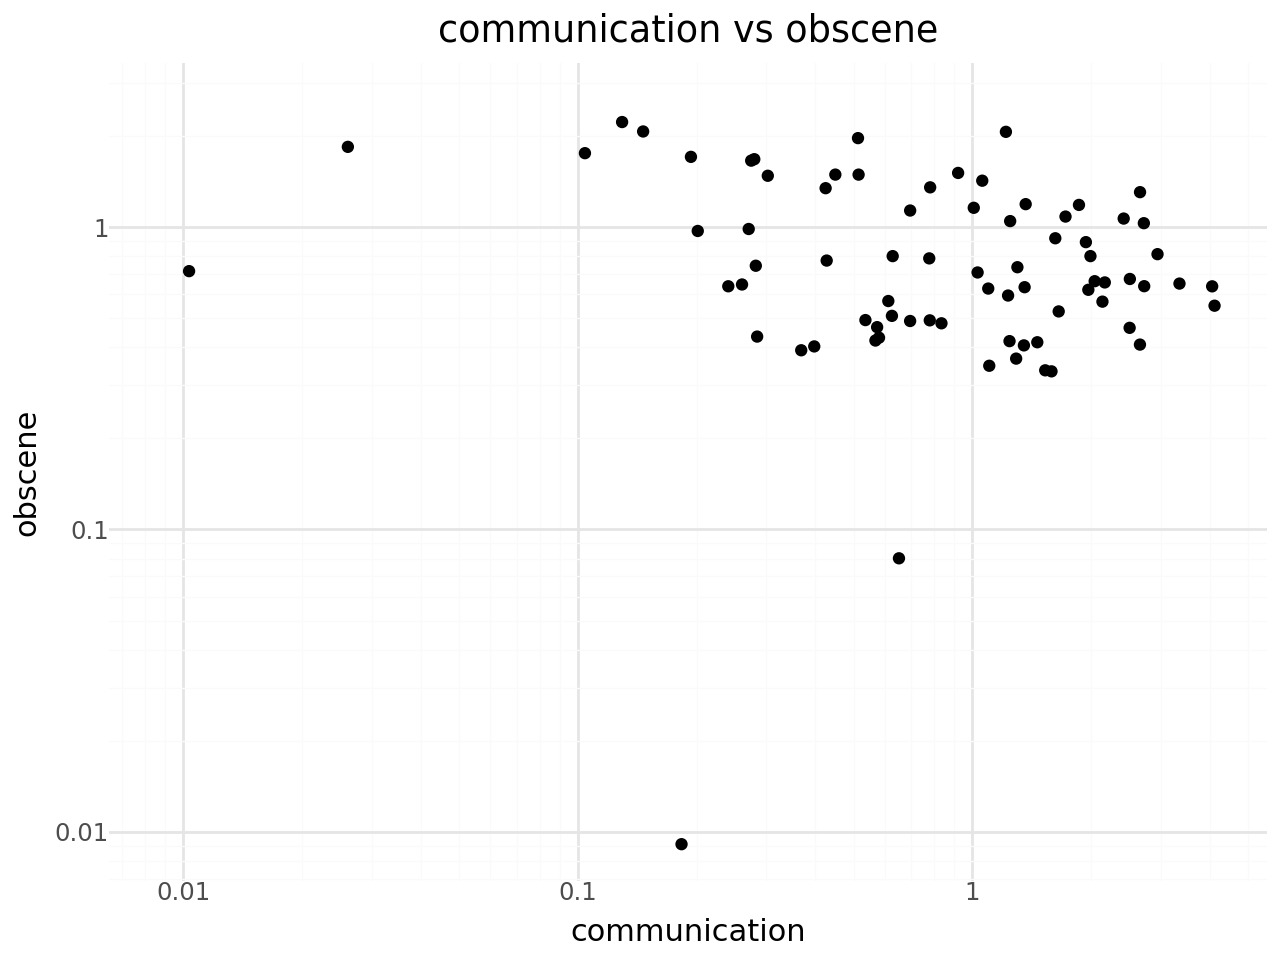

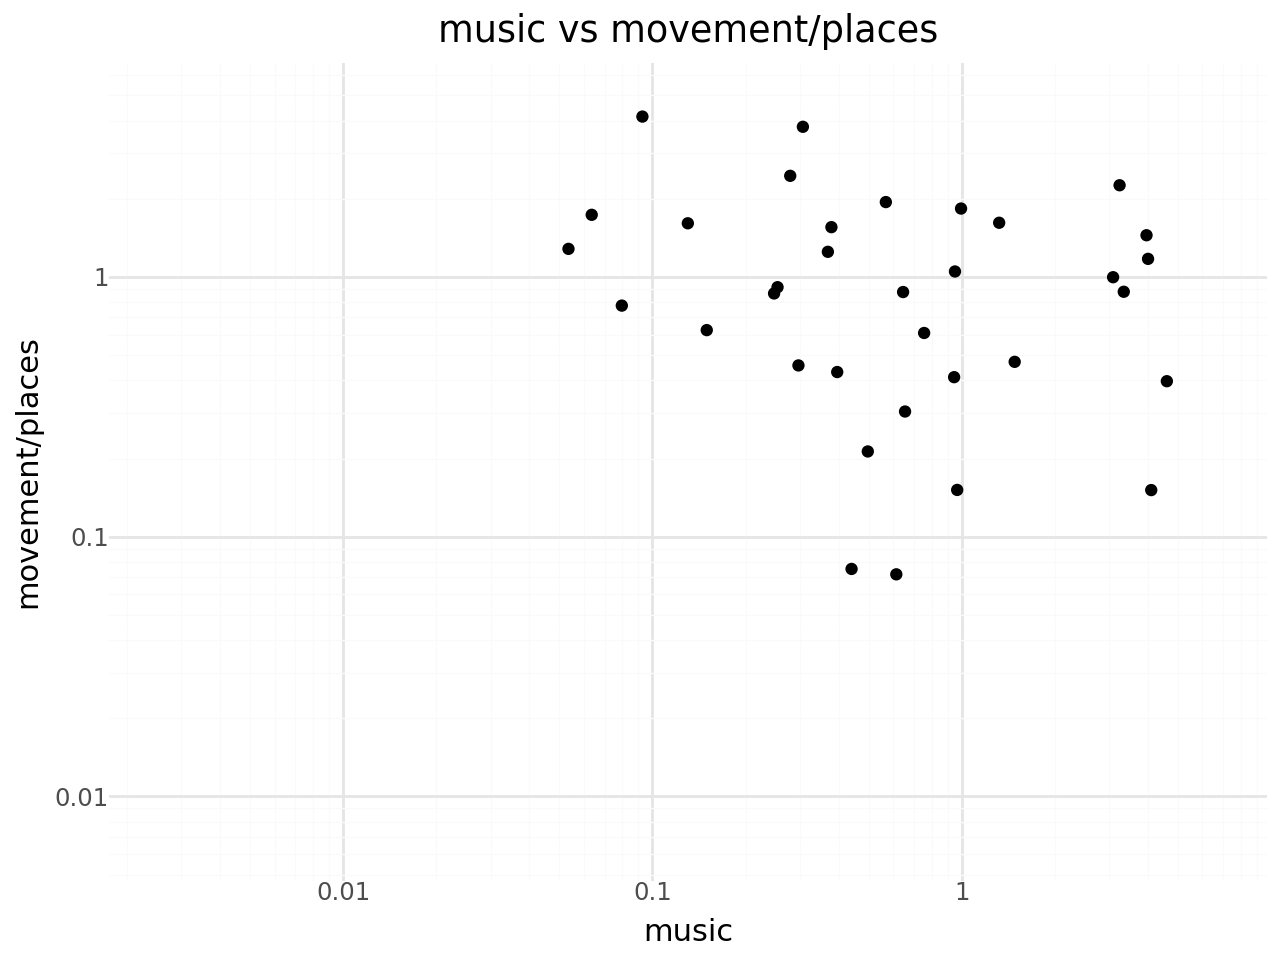

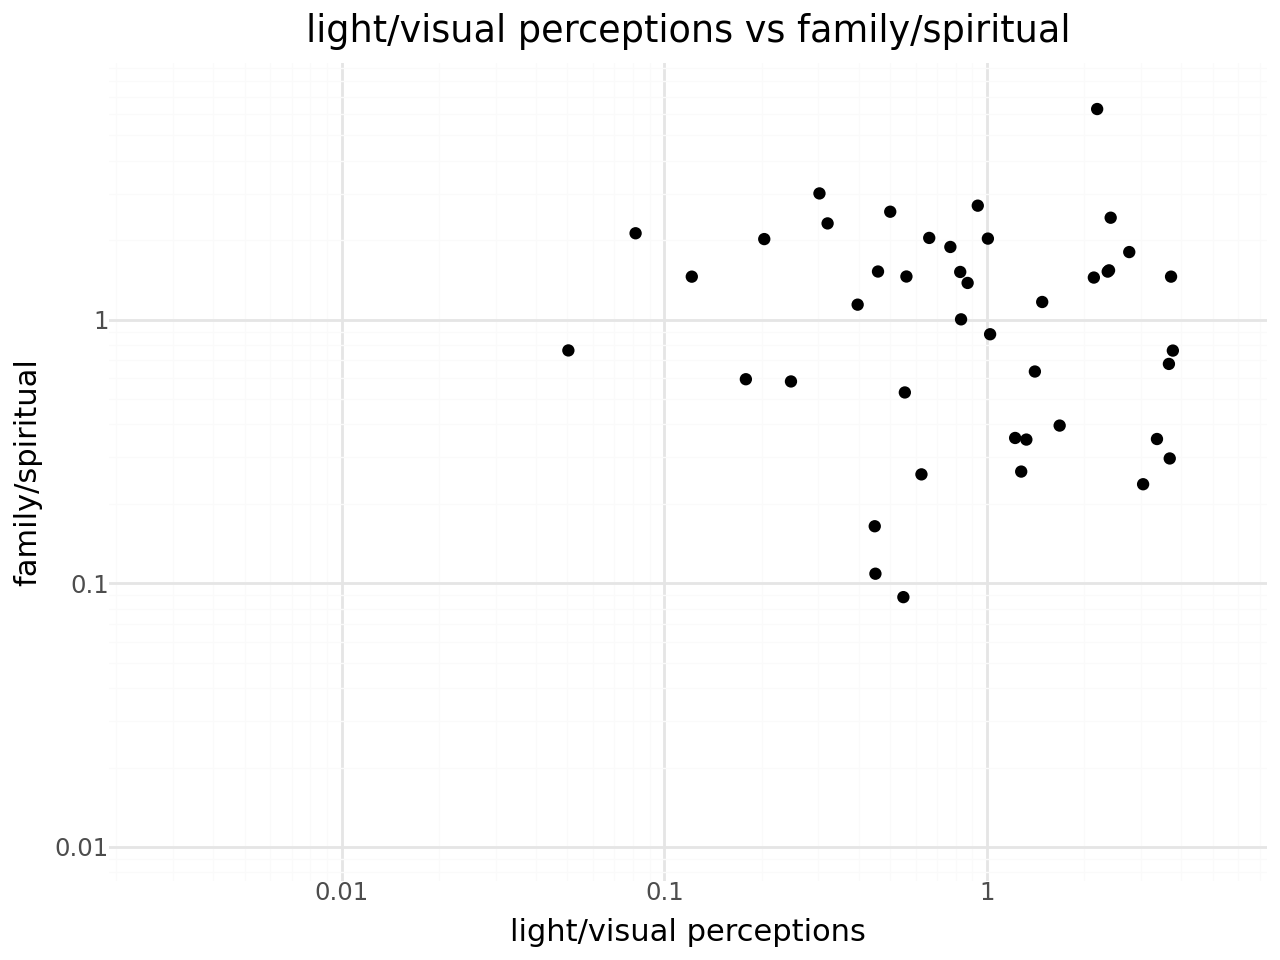

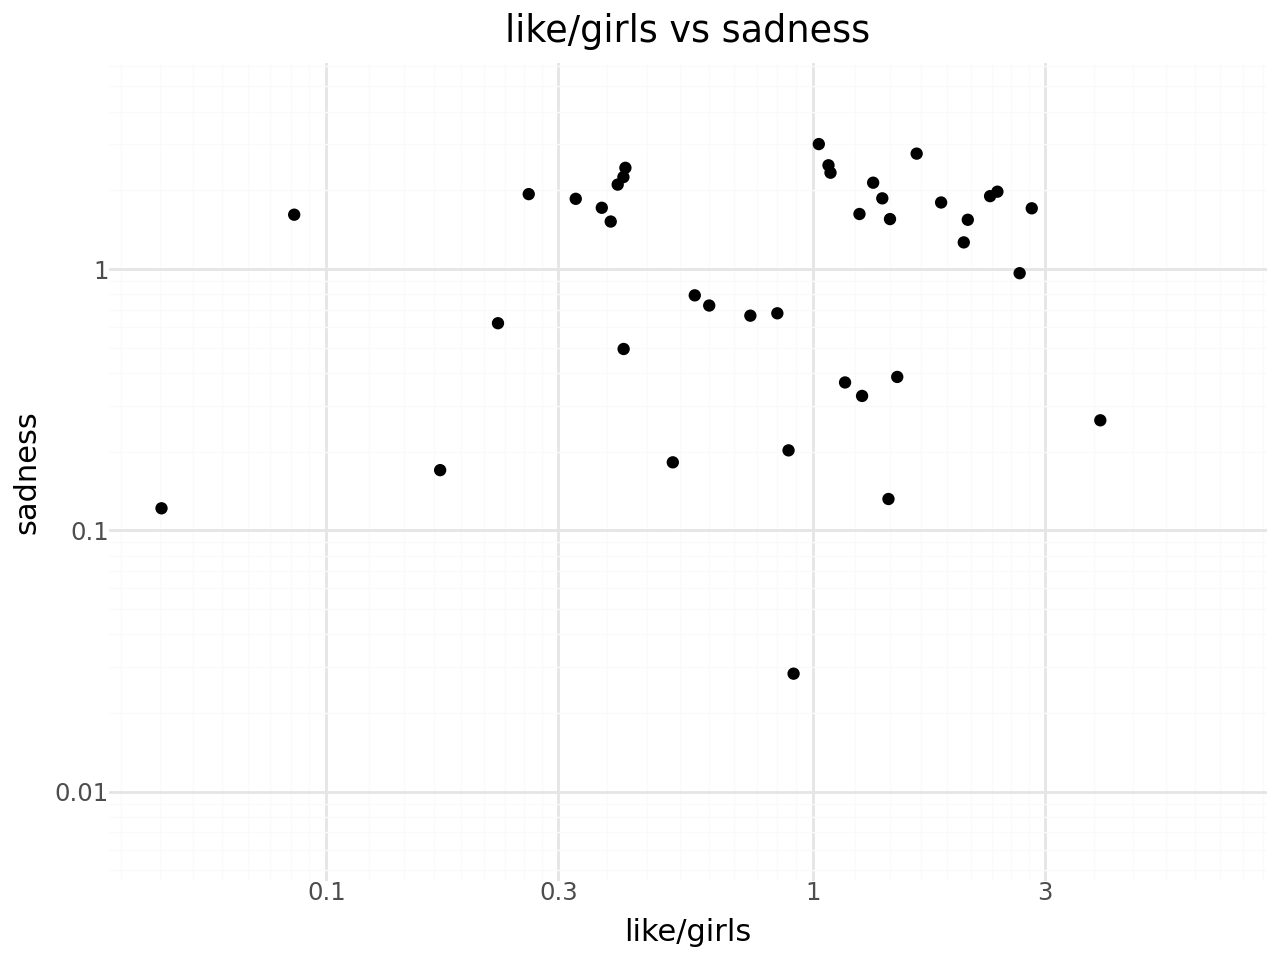

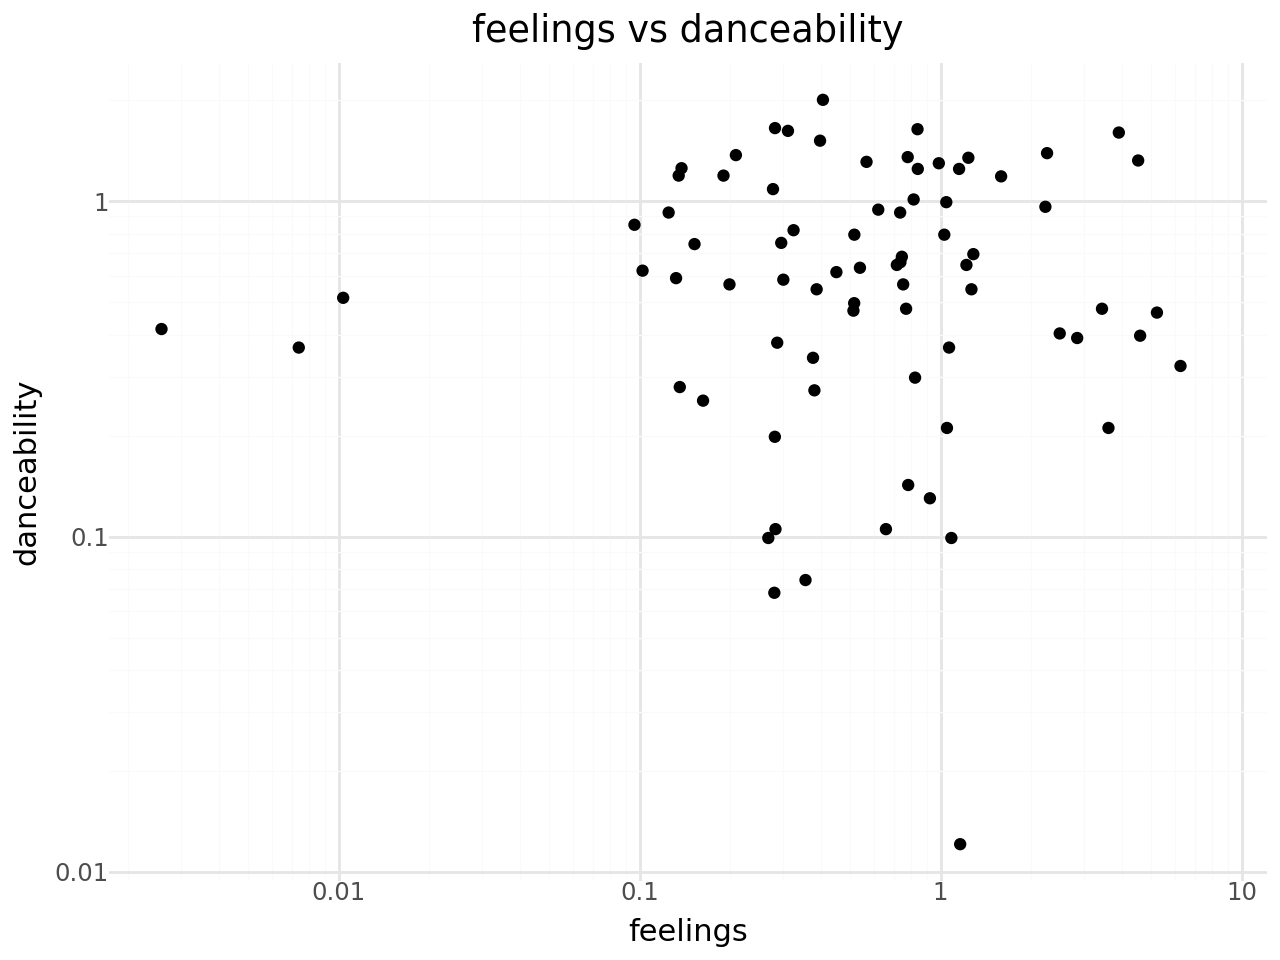

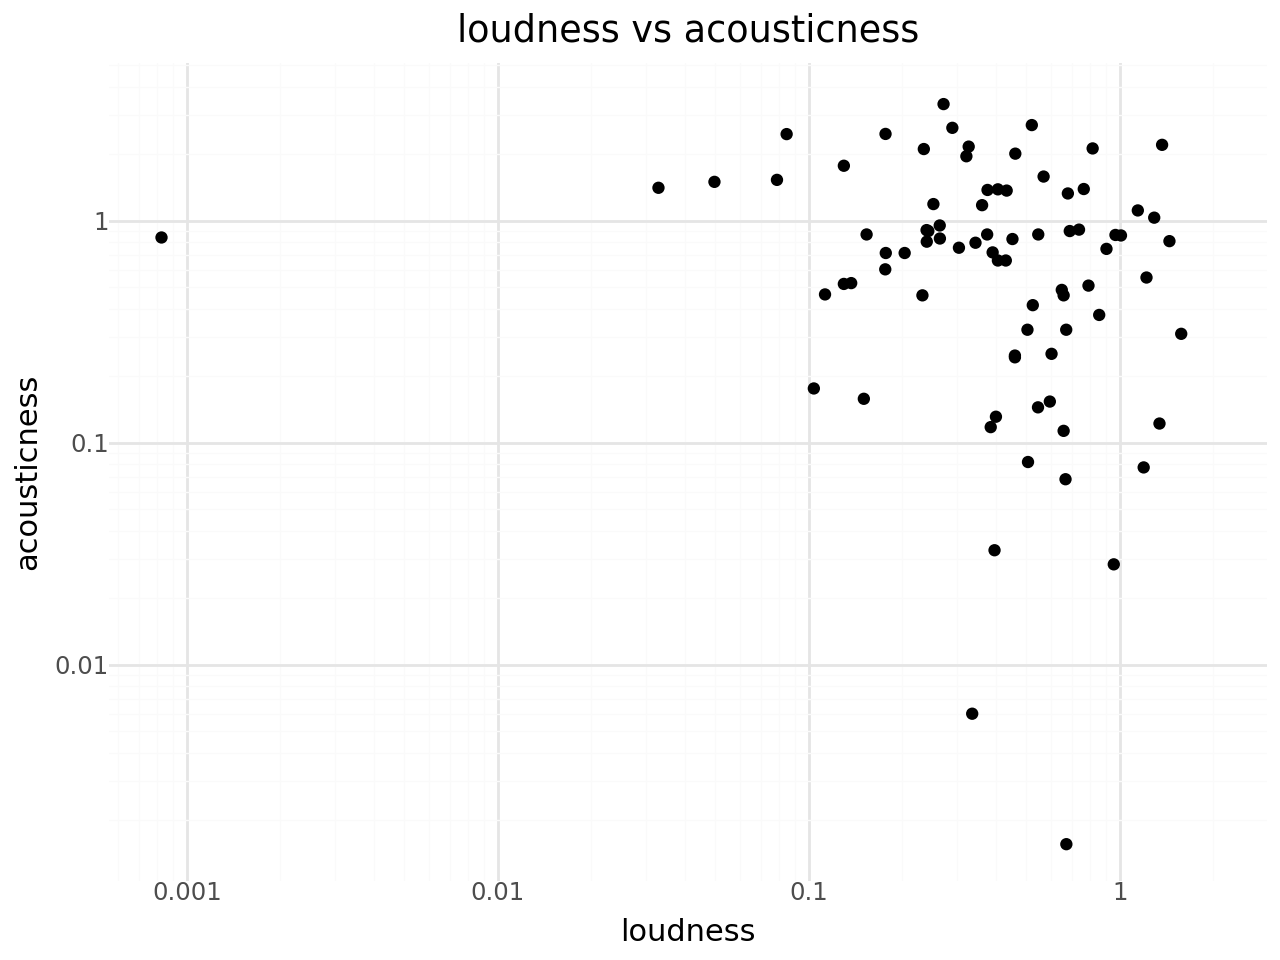

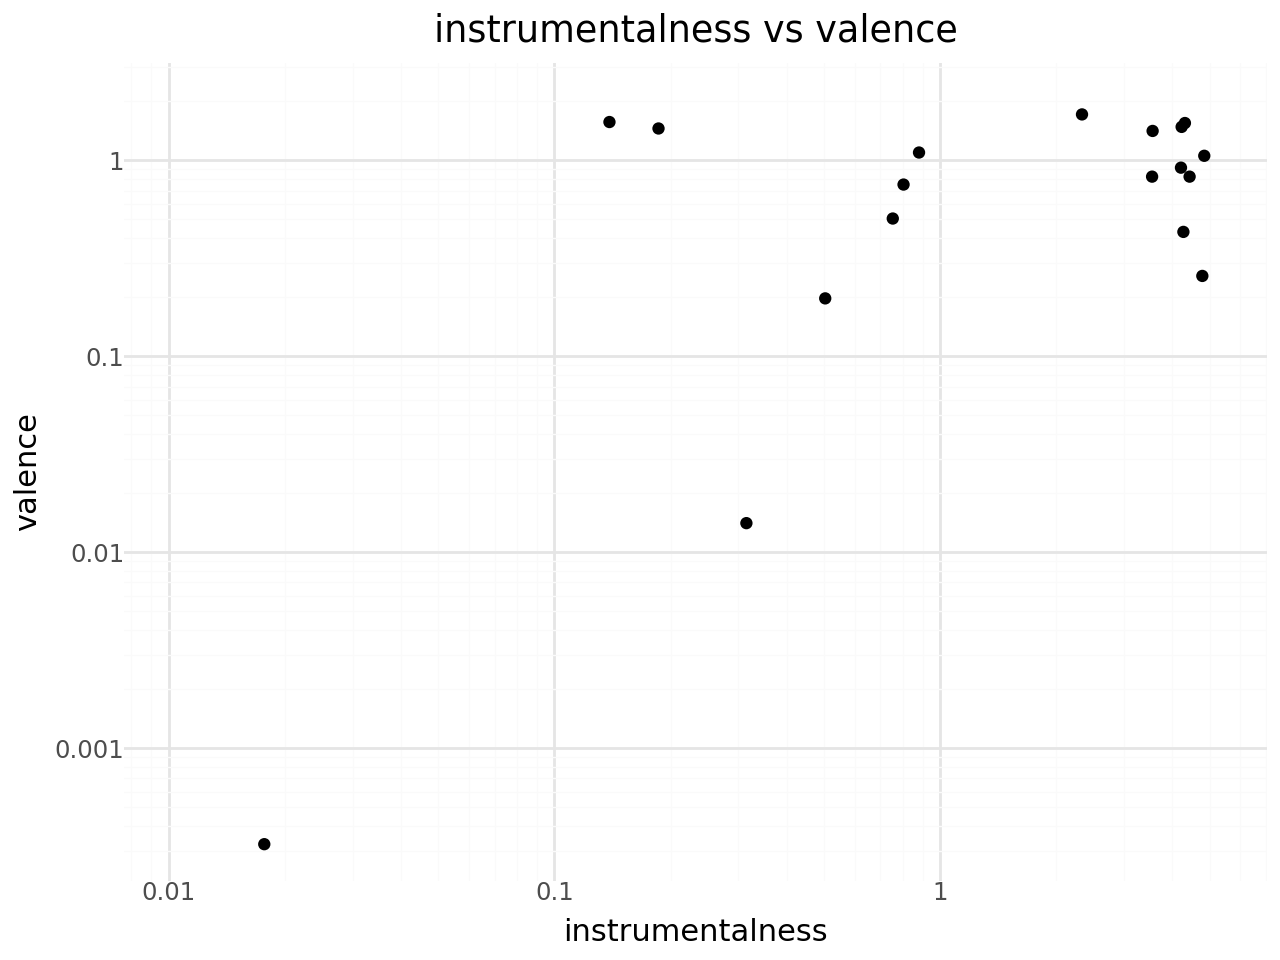

IndexError: index 0 is out of bounds for axis 0 with size 0

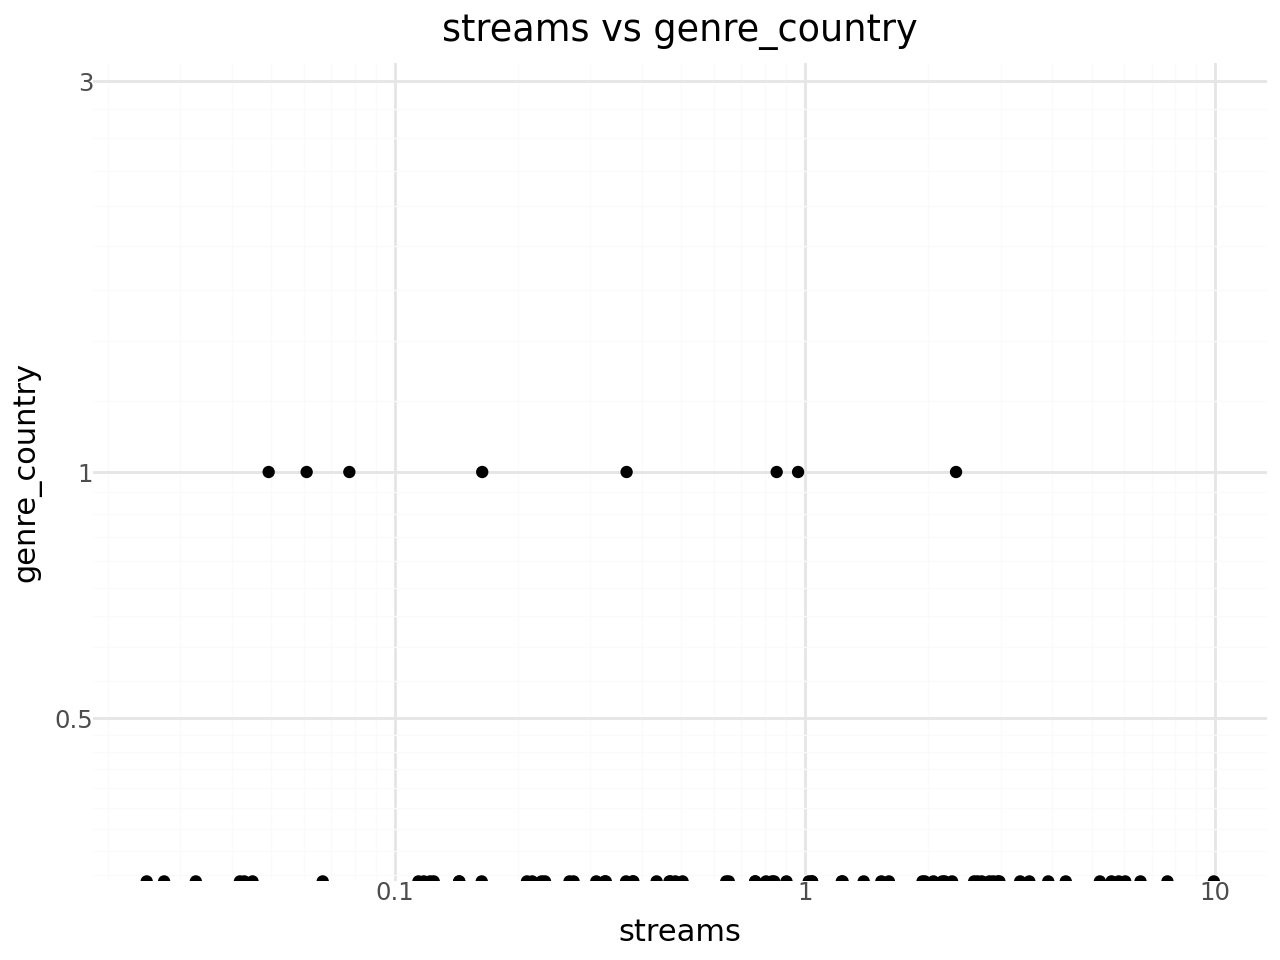

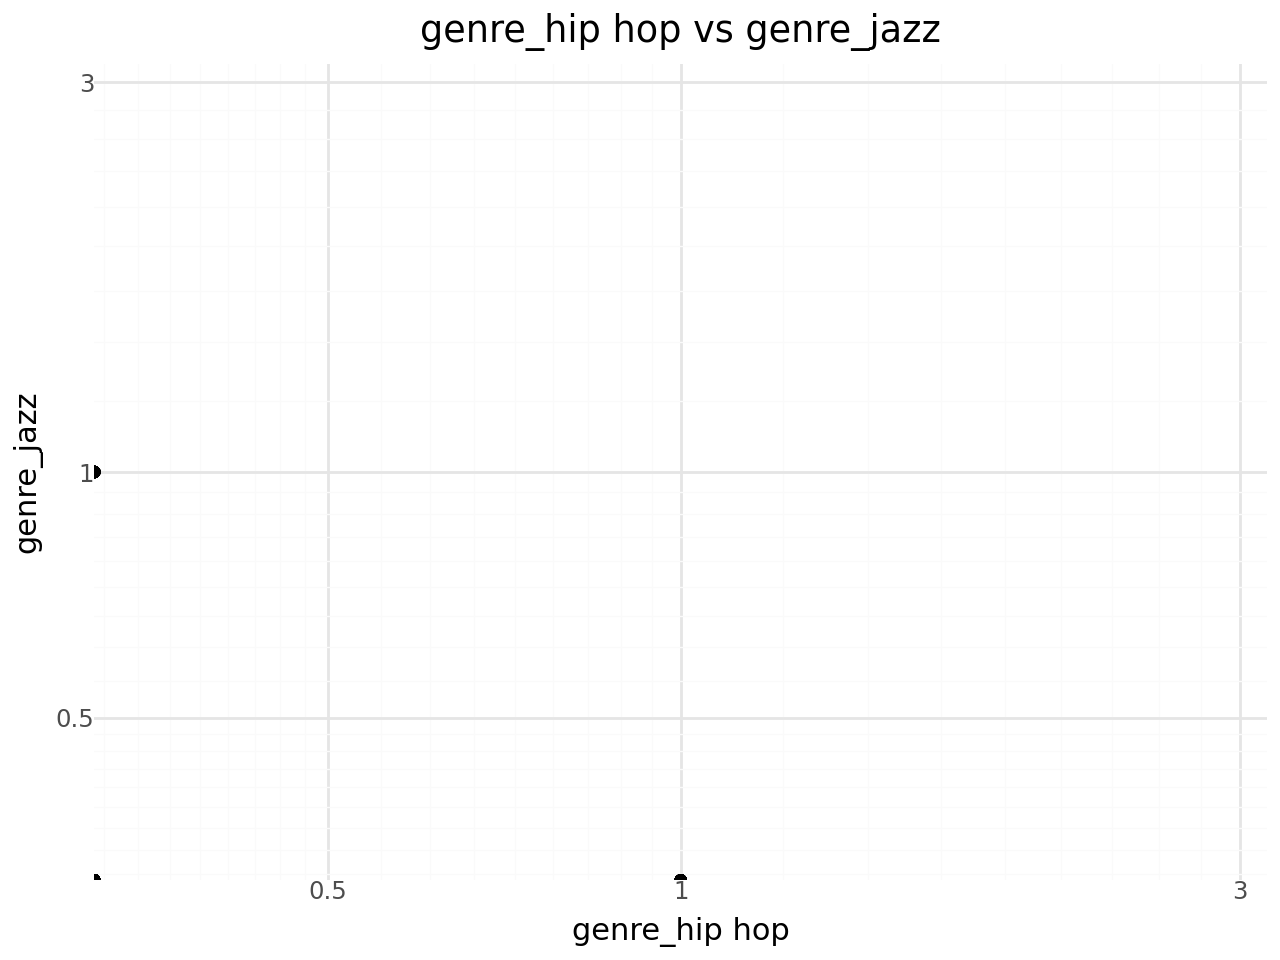

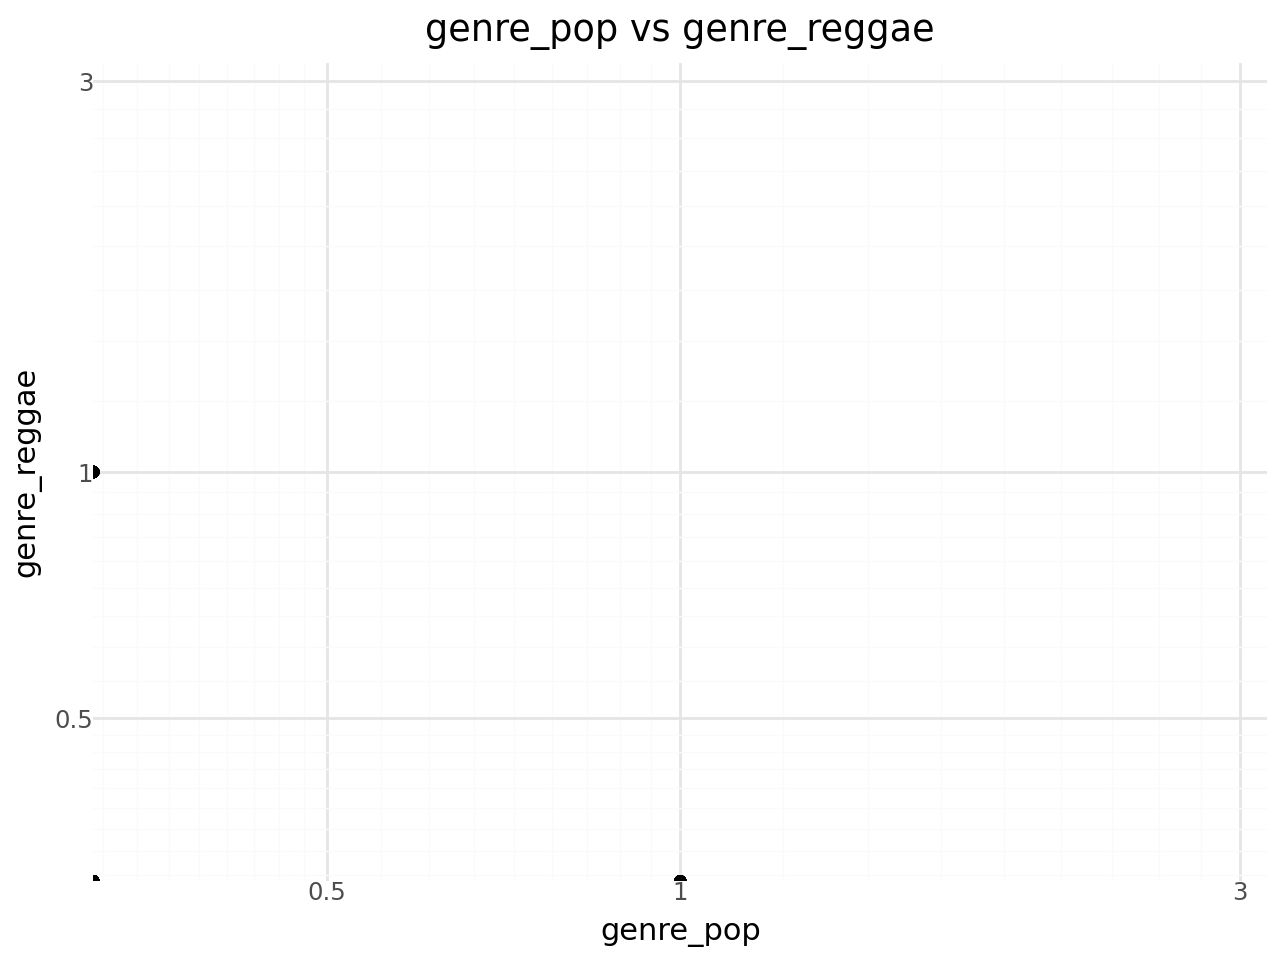

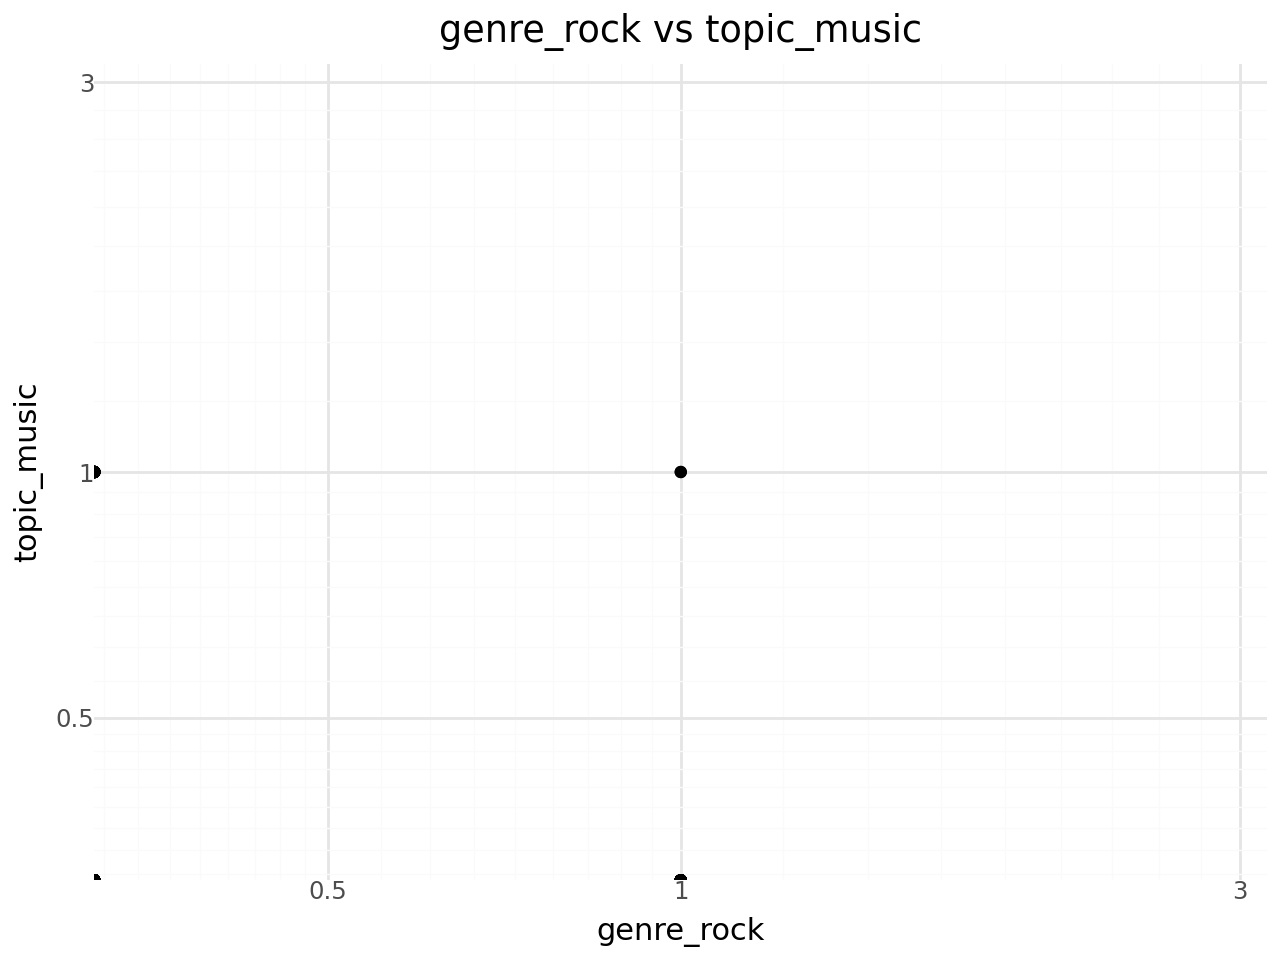

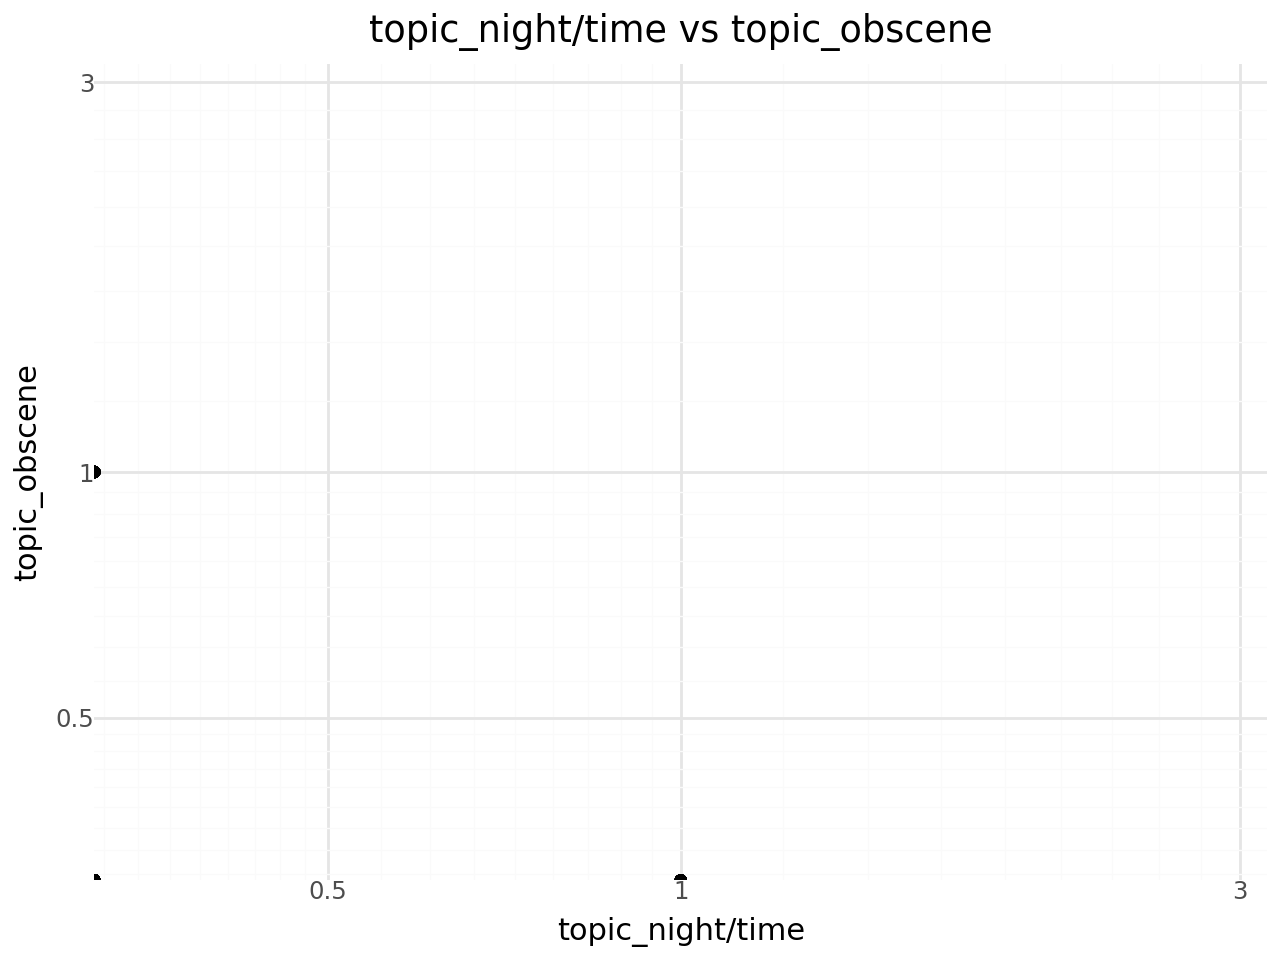

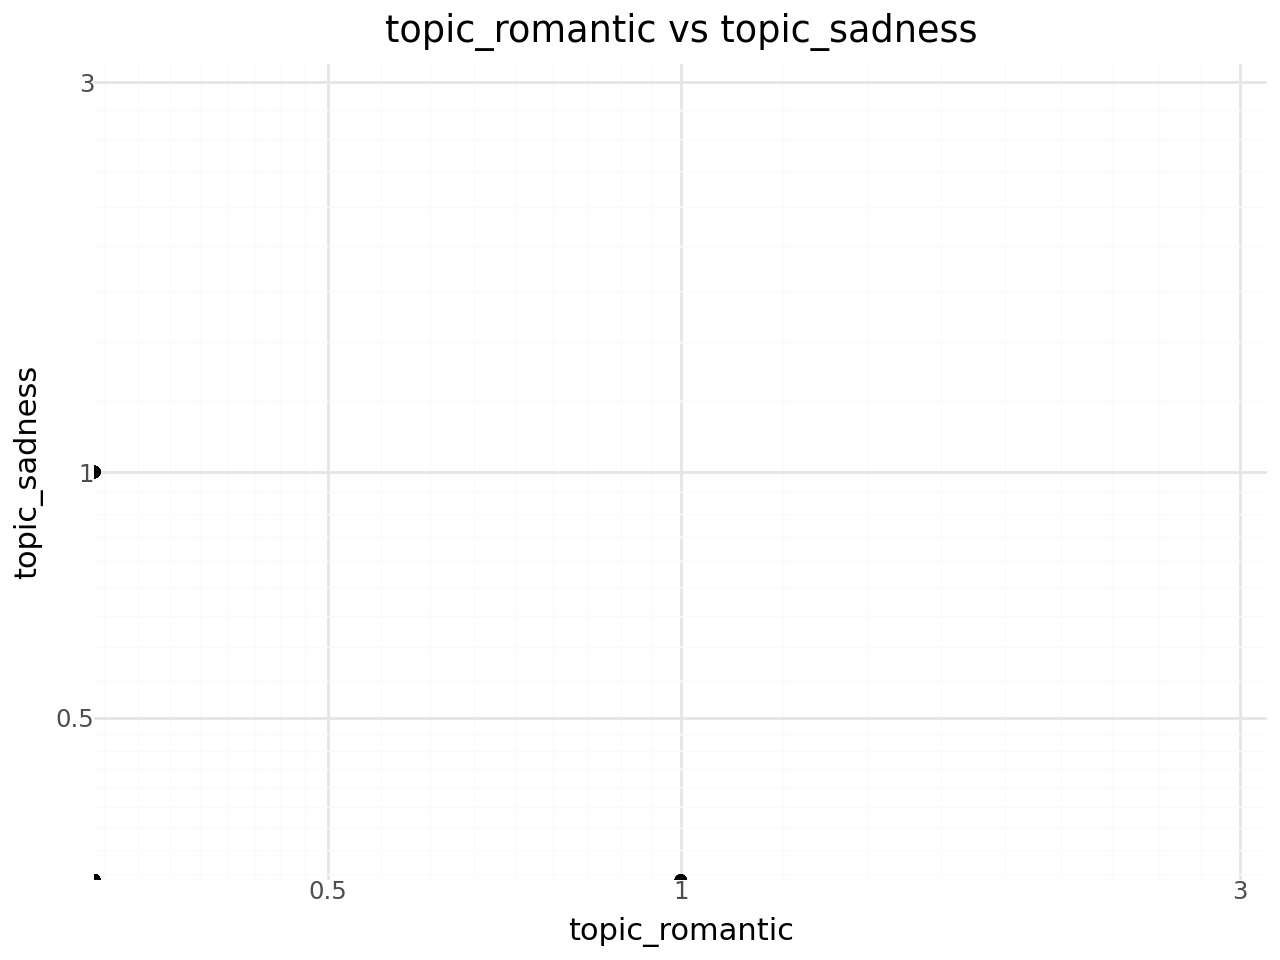

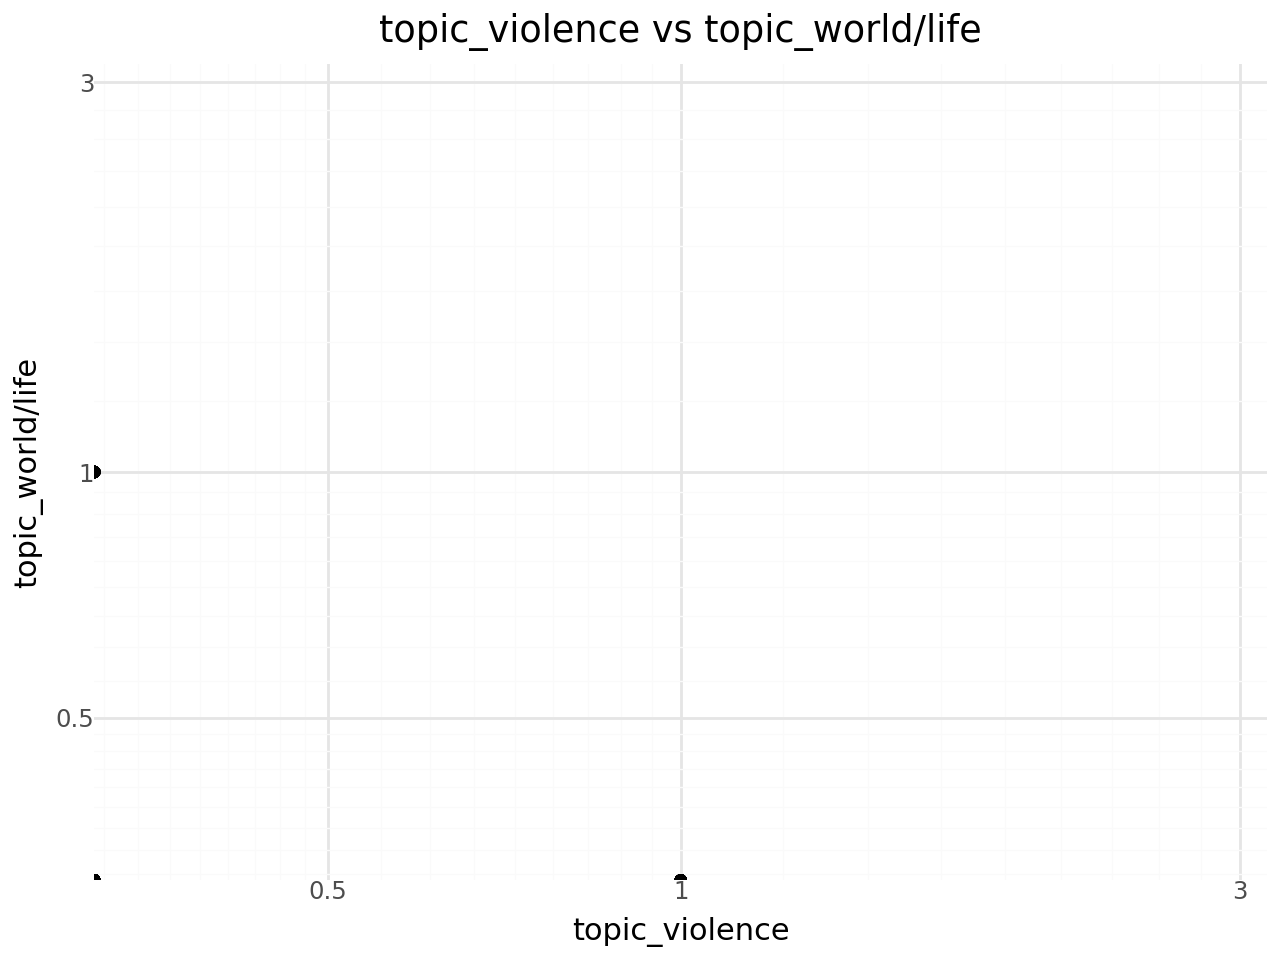

In [ ]:
#Make ggplot scatterplots of pairs of features using cleaned data to give  a little bit of information about the data, and to help  decide which
#algorithm to use


# List of columns
columns = ['len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability',
       'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
       'age', 'streams', 'genre_country', 'genre_hip hop', 'genre_jazz',
       'genre_pop', 'genre_reggae', 'genre_rock', 'topic_music',
       'topic_night/time', 'topic_obscene', 'topic_romantic', 'topic_sadness',
       'topic_violence', 'topic_world/life']

# Loop through the list in pairs
for i in range(0, len(columns) - 1, 2):
    col_x = columns[i]
    col_y = columns[i + 1]


    plot = (ggplot(X_df, aes(x=col_x, y=col_y)) +
            geom_point() +
            labs(title=f"{col_x} vs {col_y}",
                 x=col_x,
                 y=col_y) +
            scale_x_log10() +  # Log scale for x-axis
            scale_y_log10() +  # Log scale for y-axis
            theme_minimal())

    display(plot)

#NOTE: There is an error for one plot due to the log scaling.

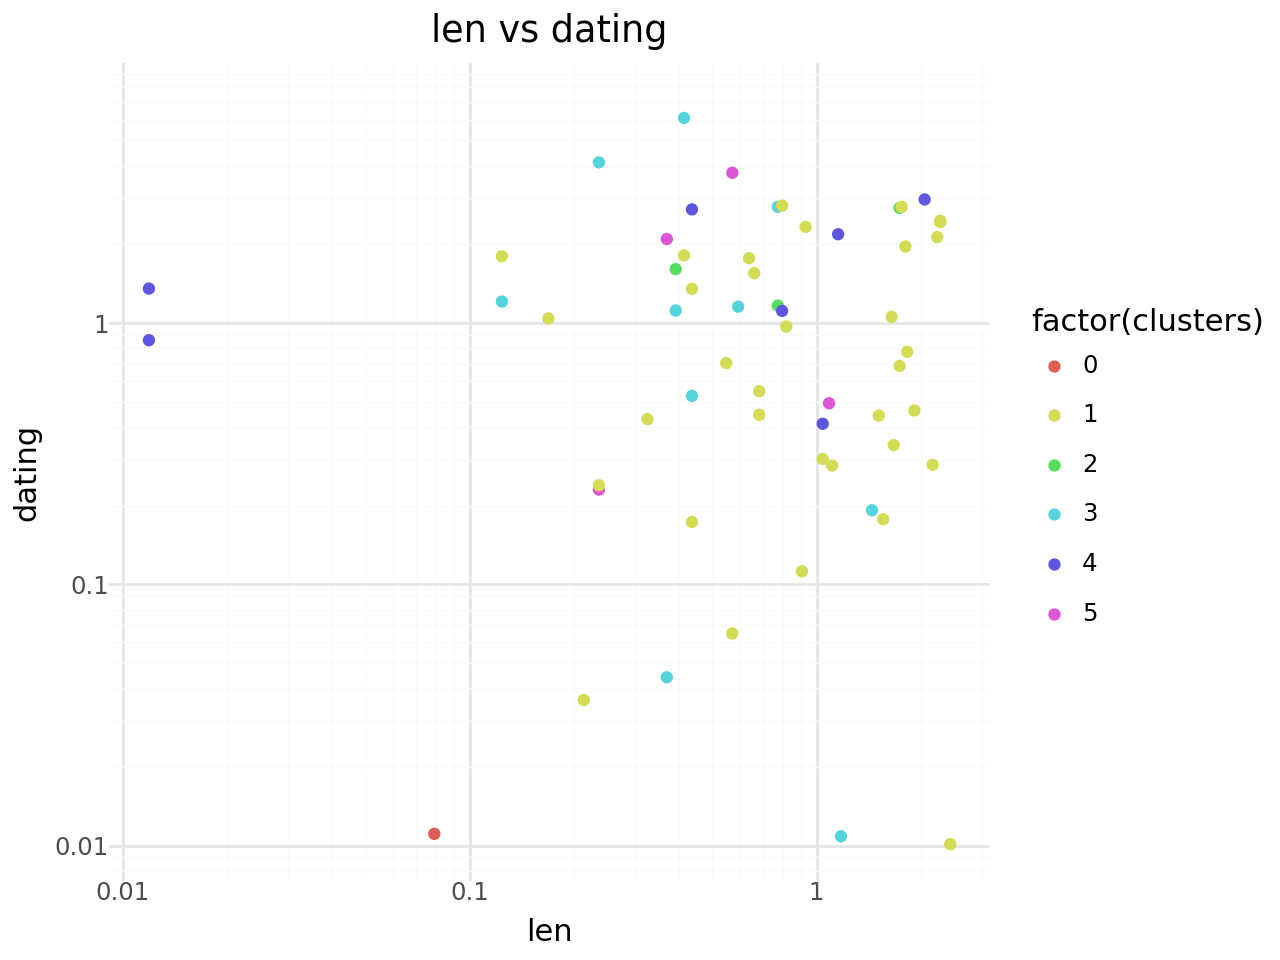

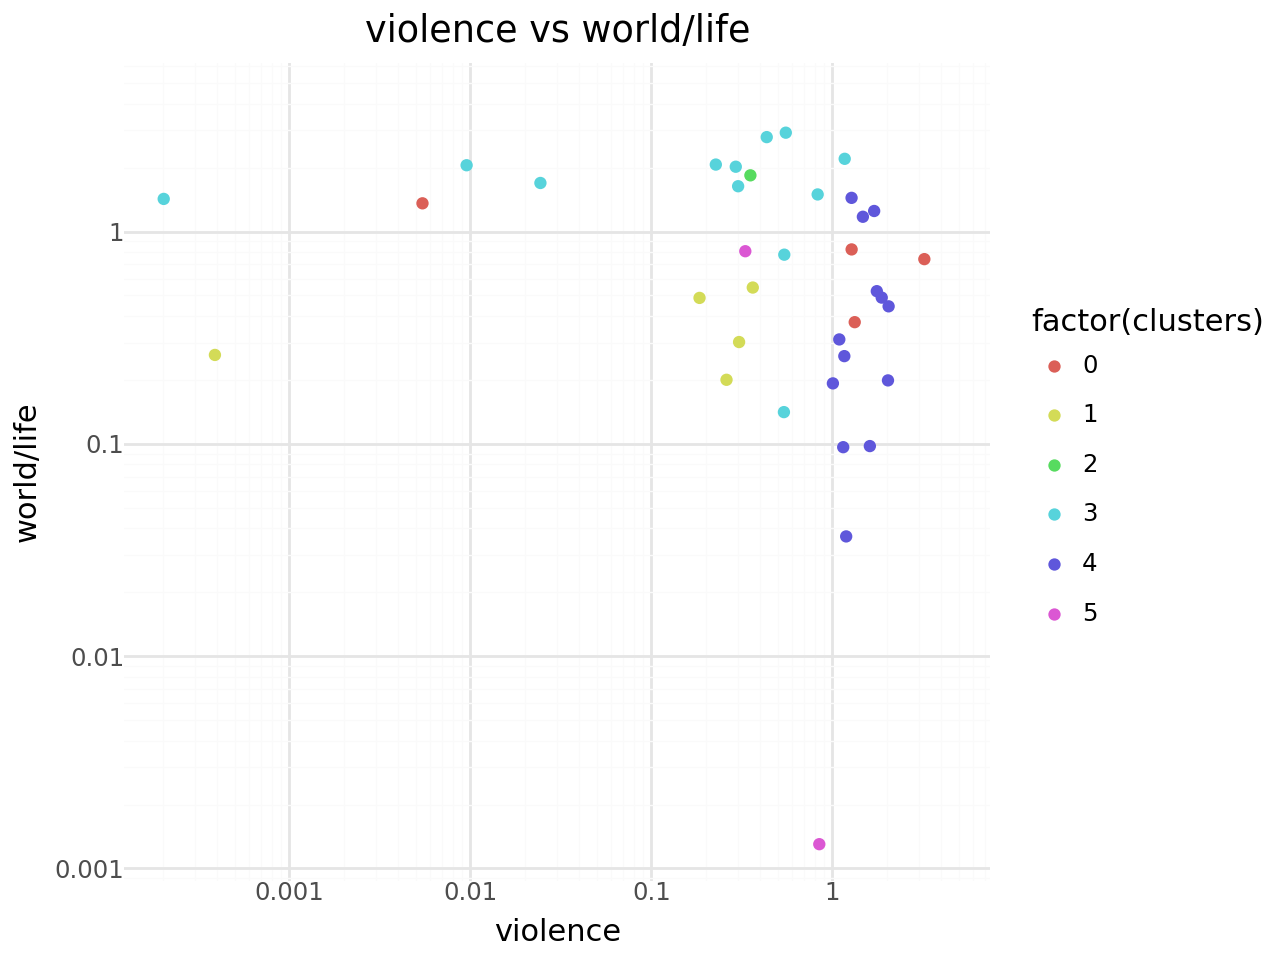

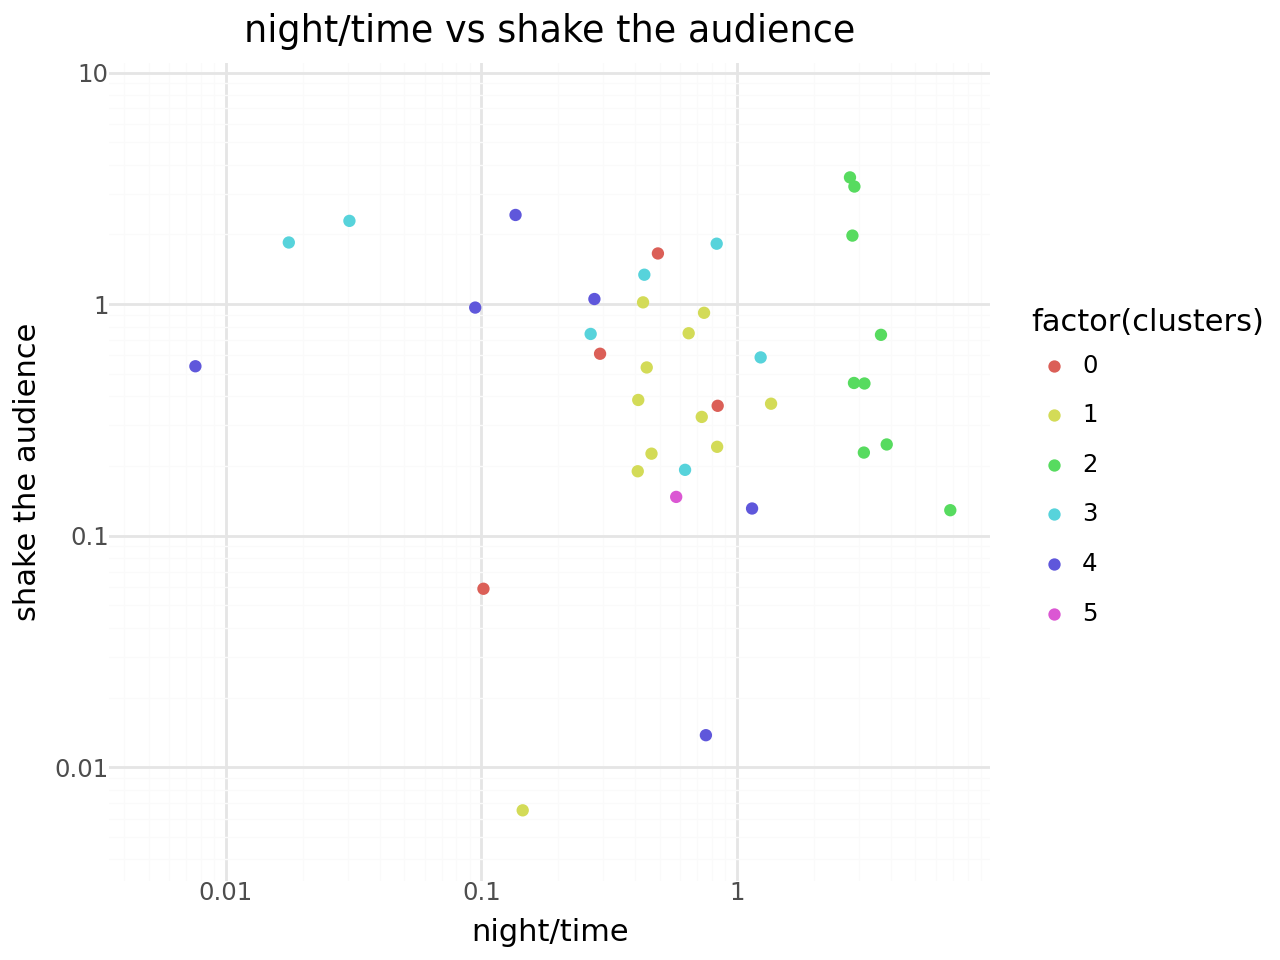

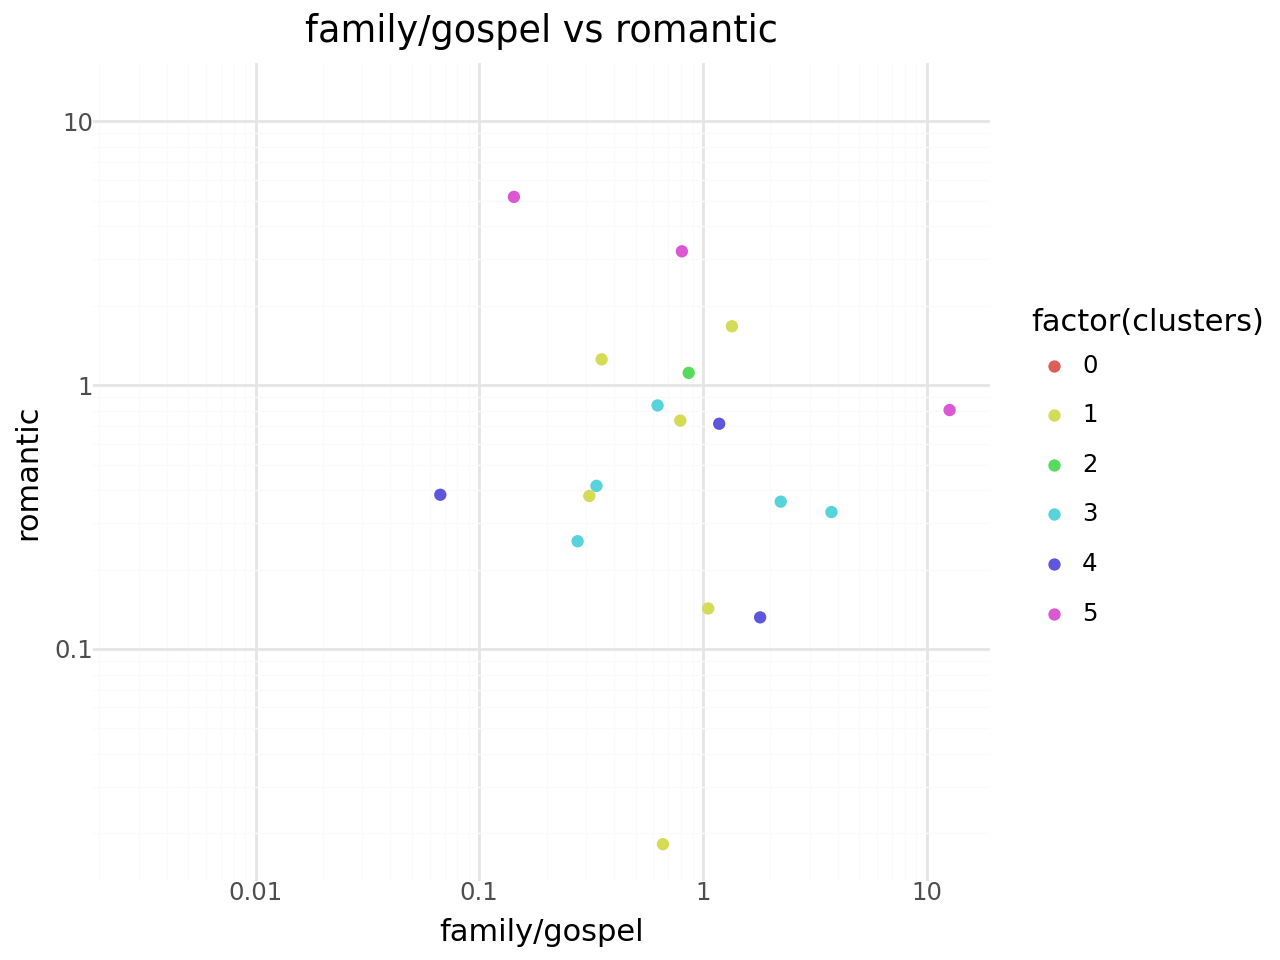

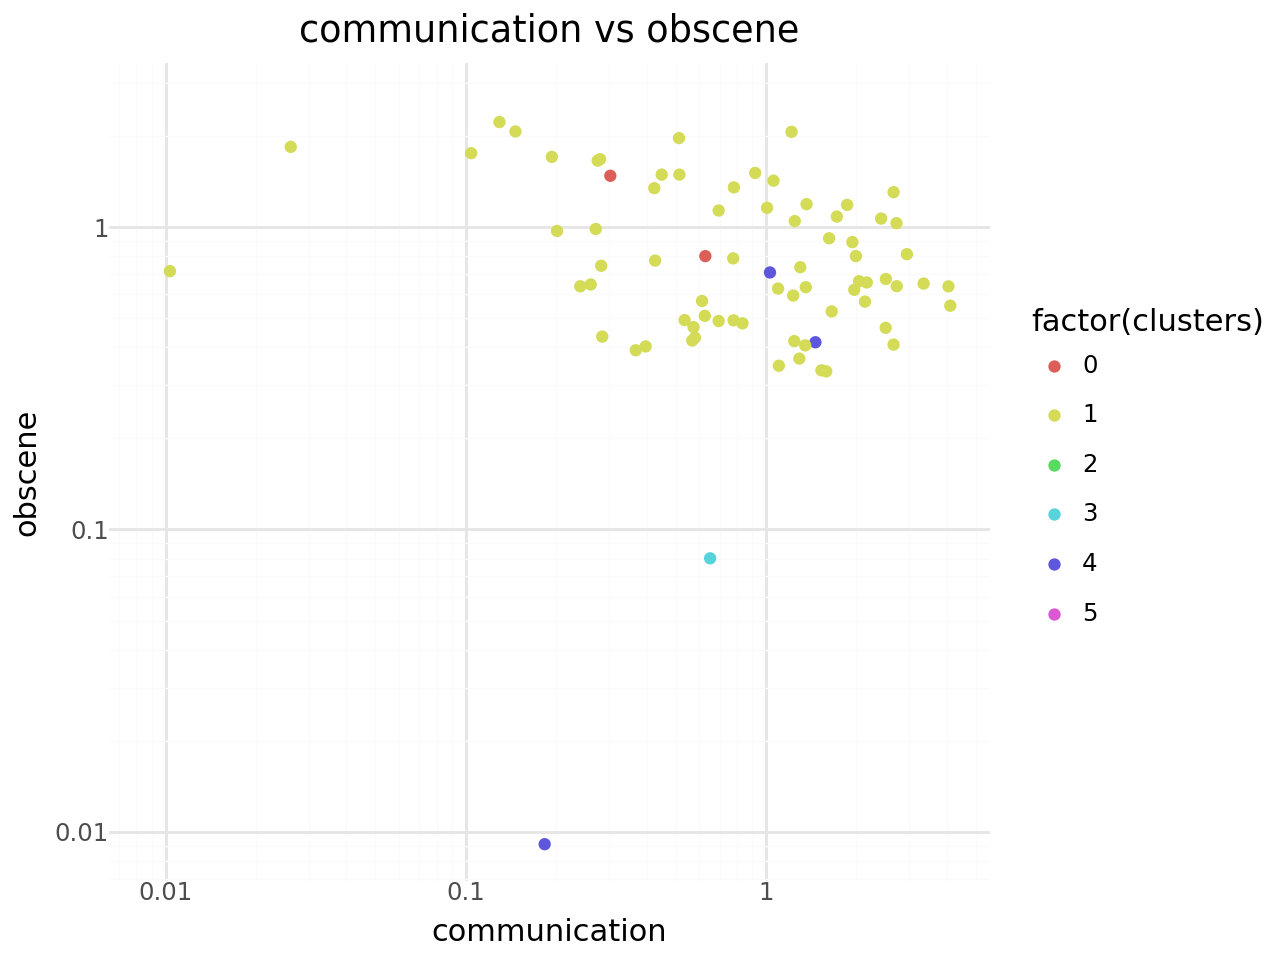

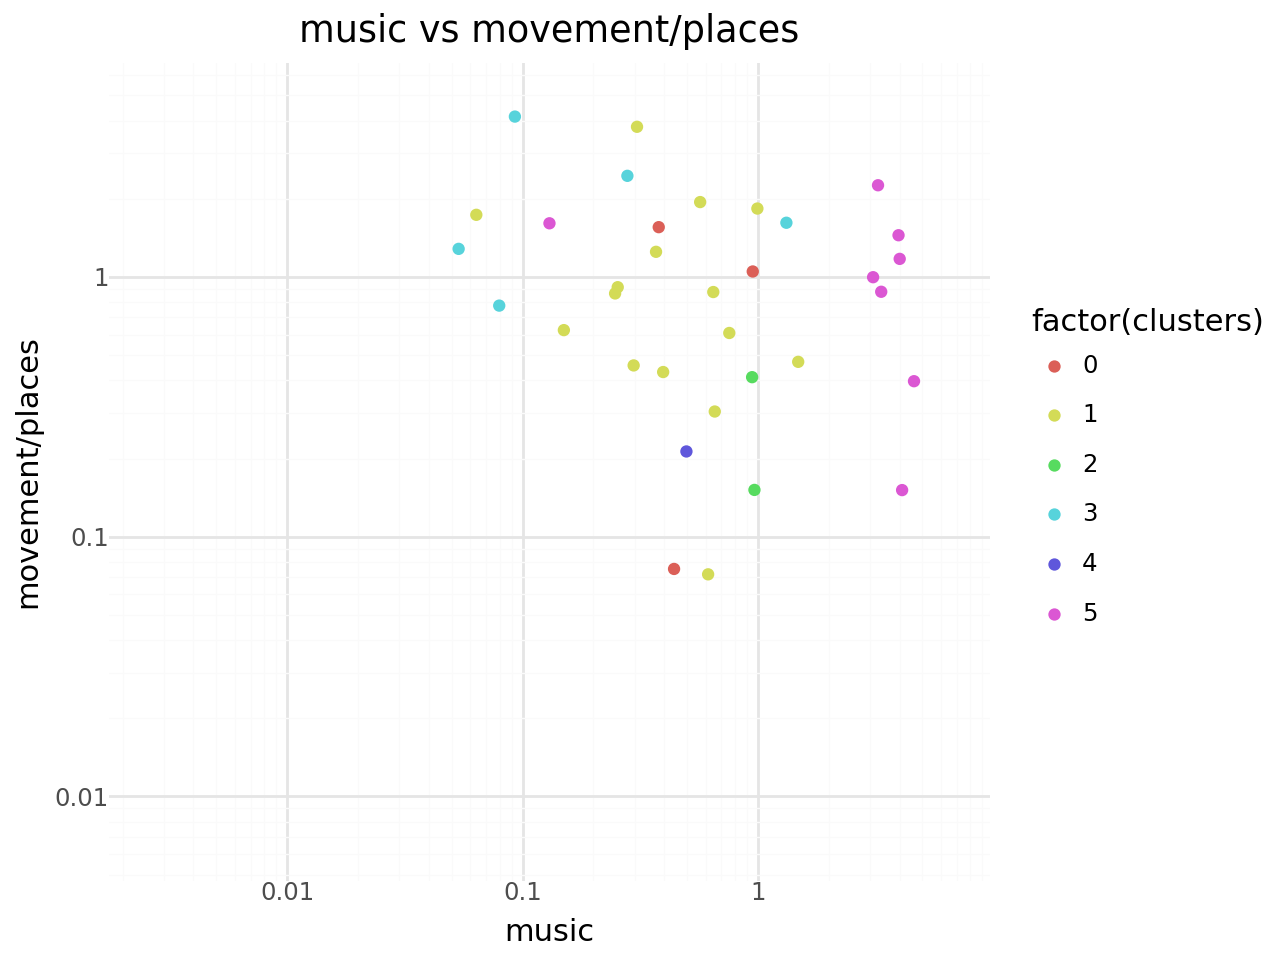

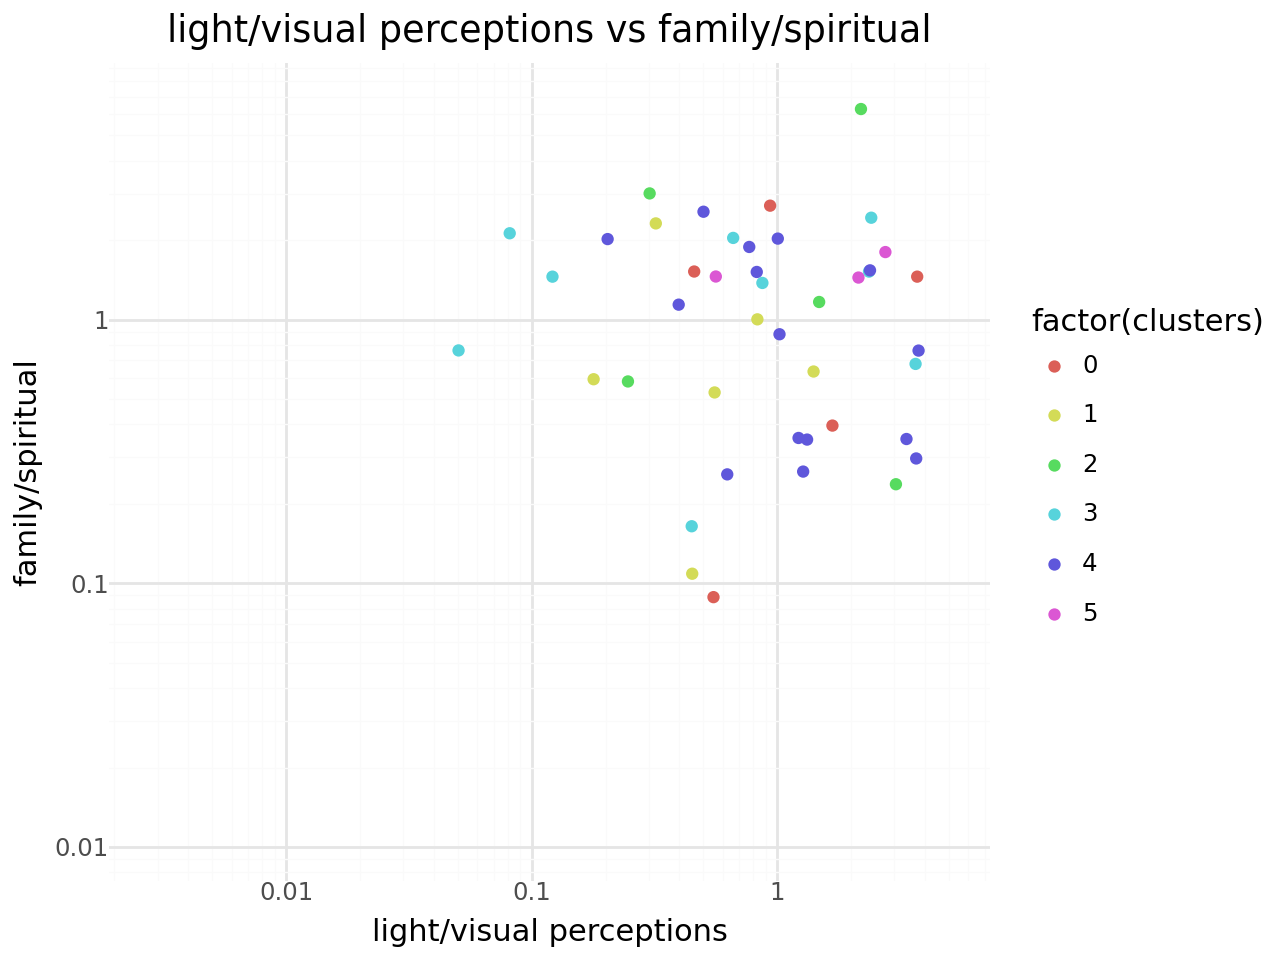

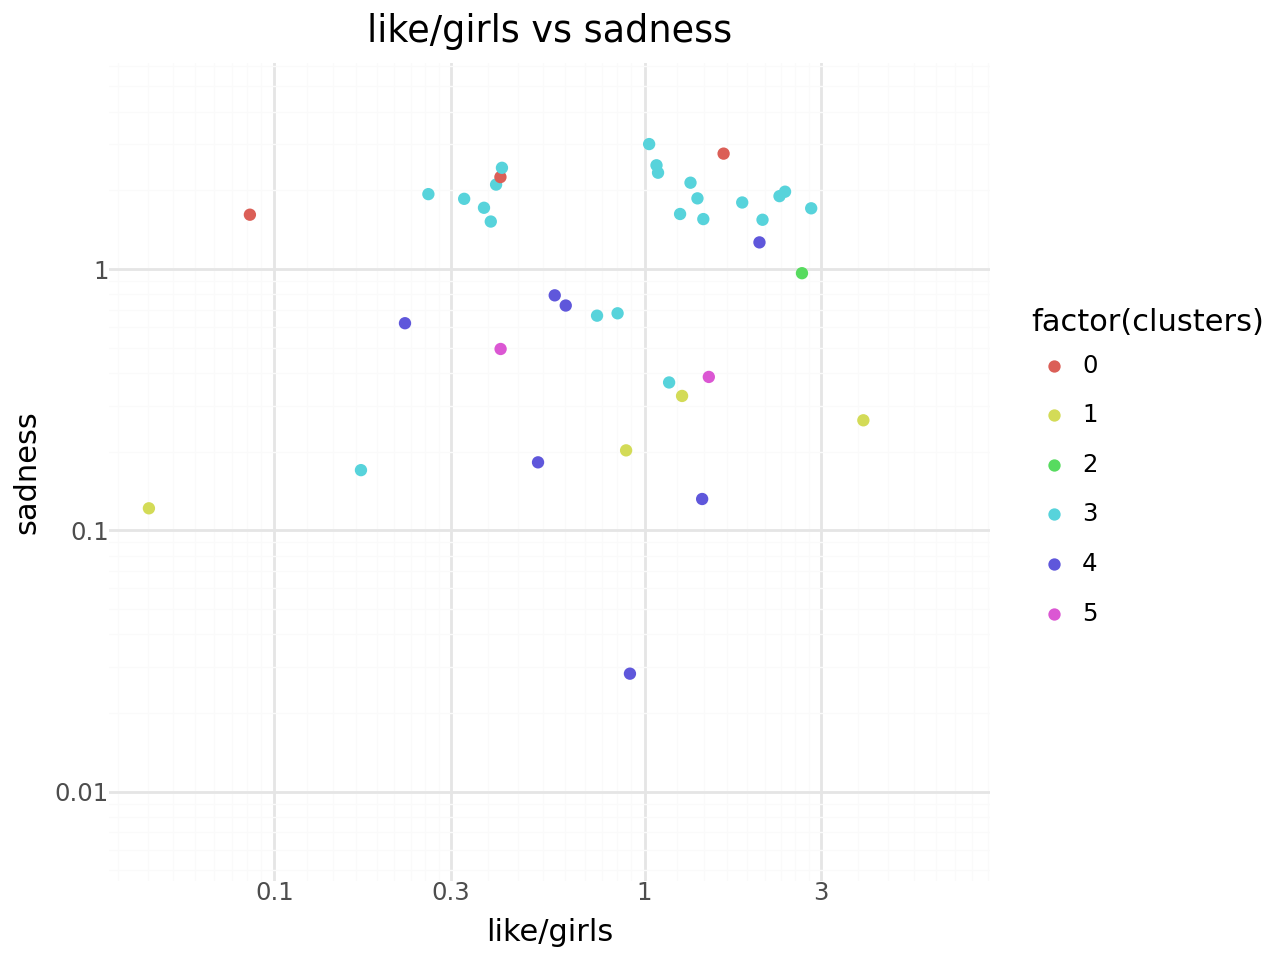

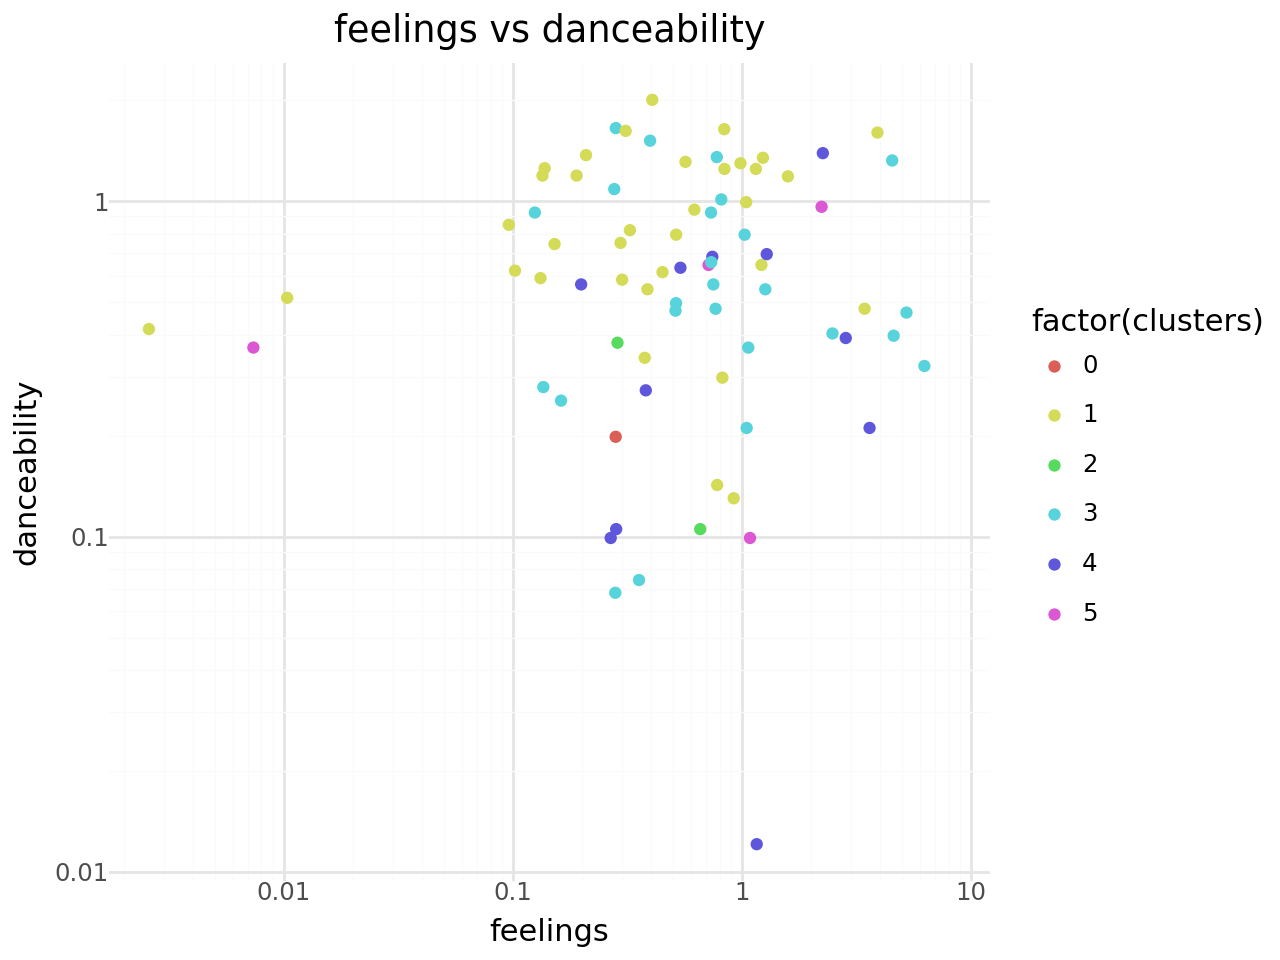

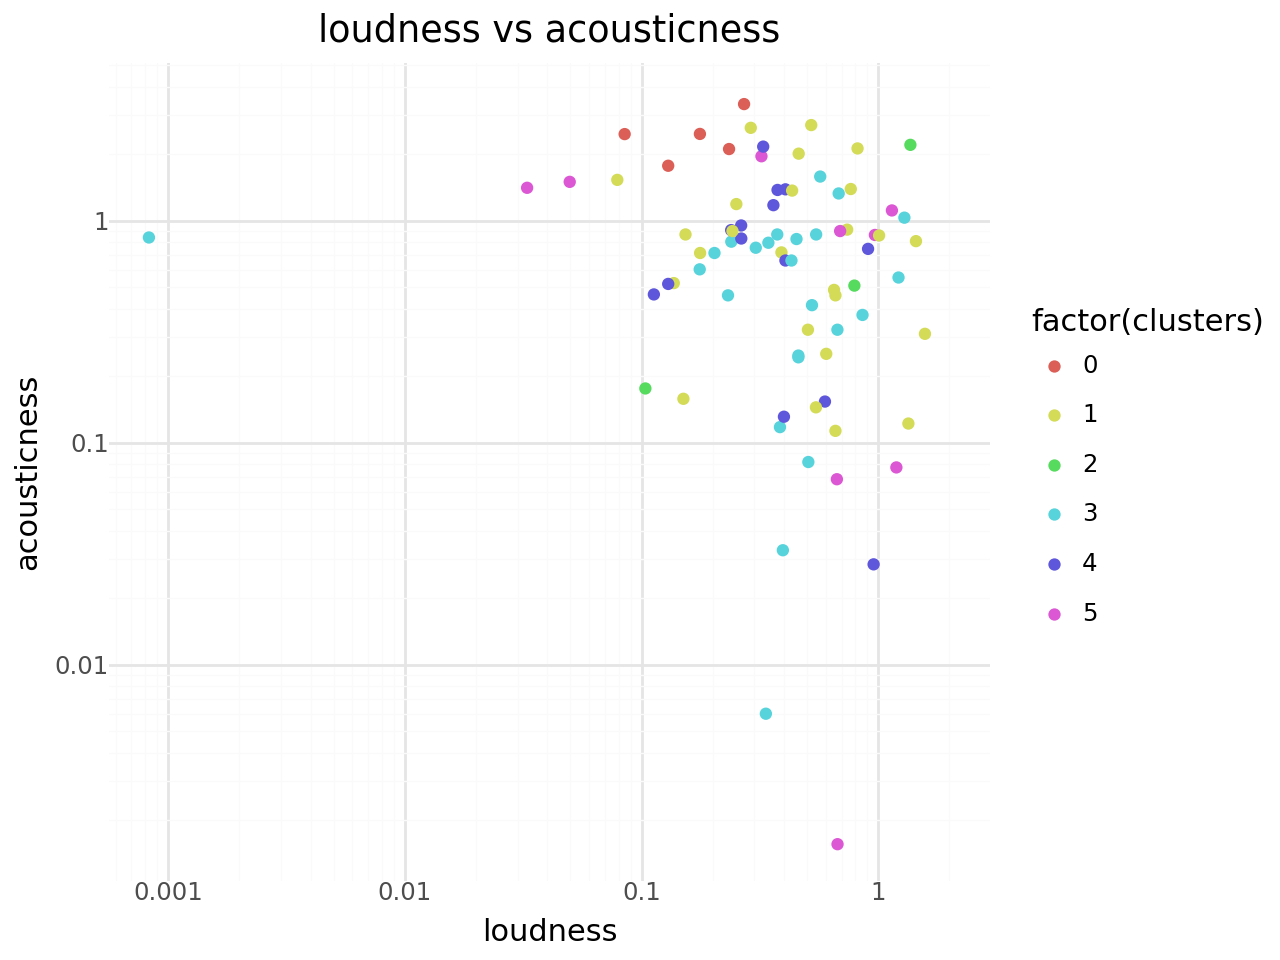

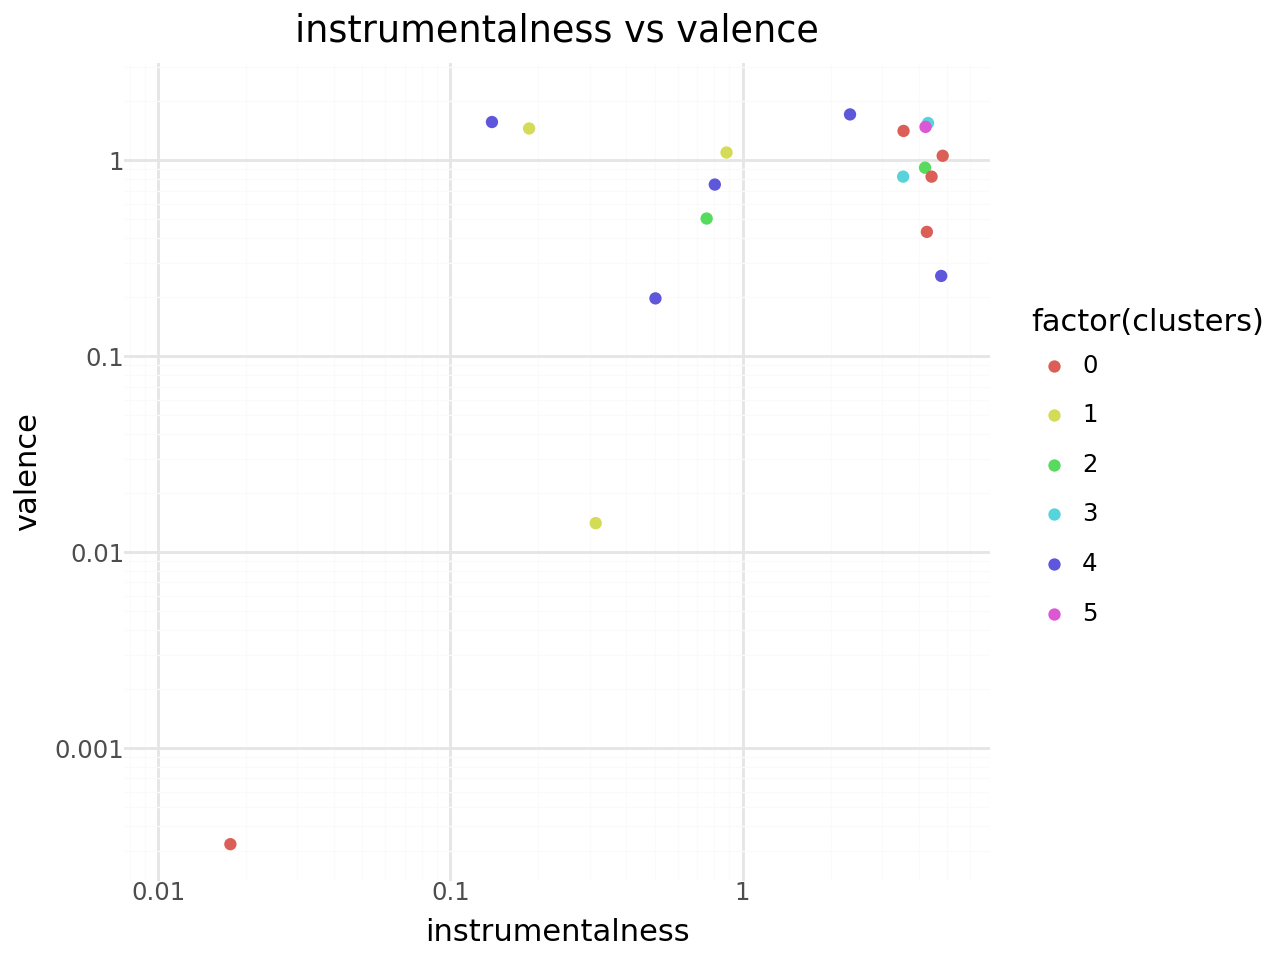

IndexError: index 0 is out of bounds for axis 0 with size 0

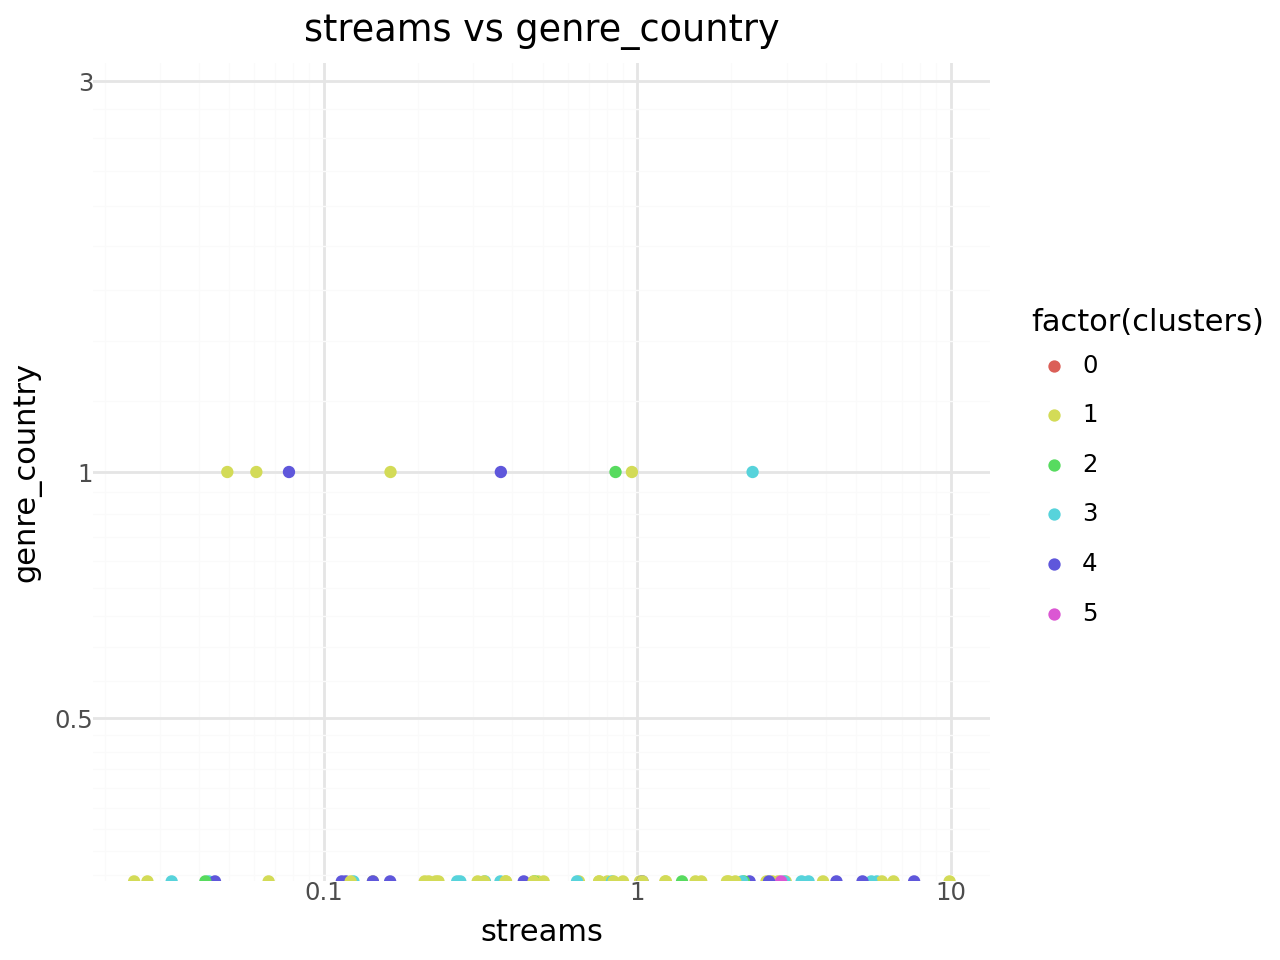

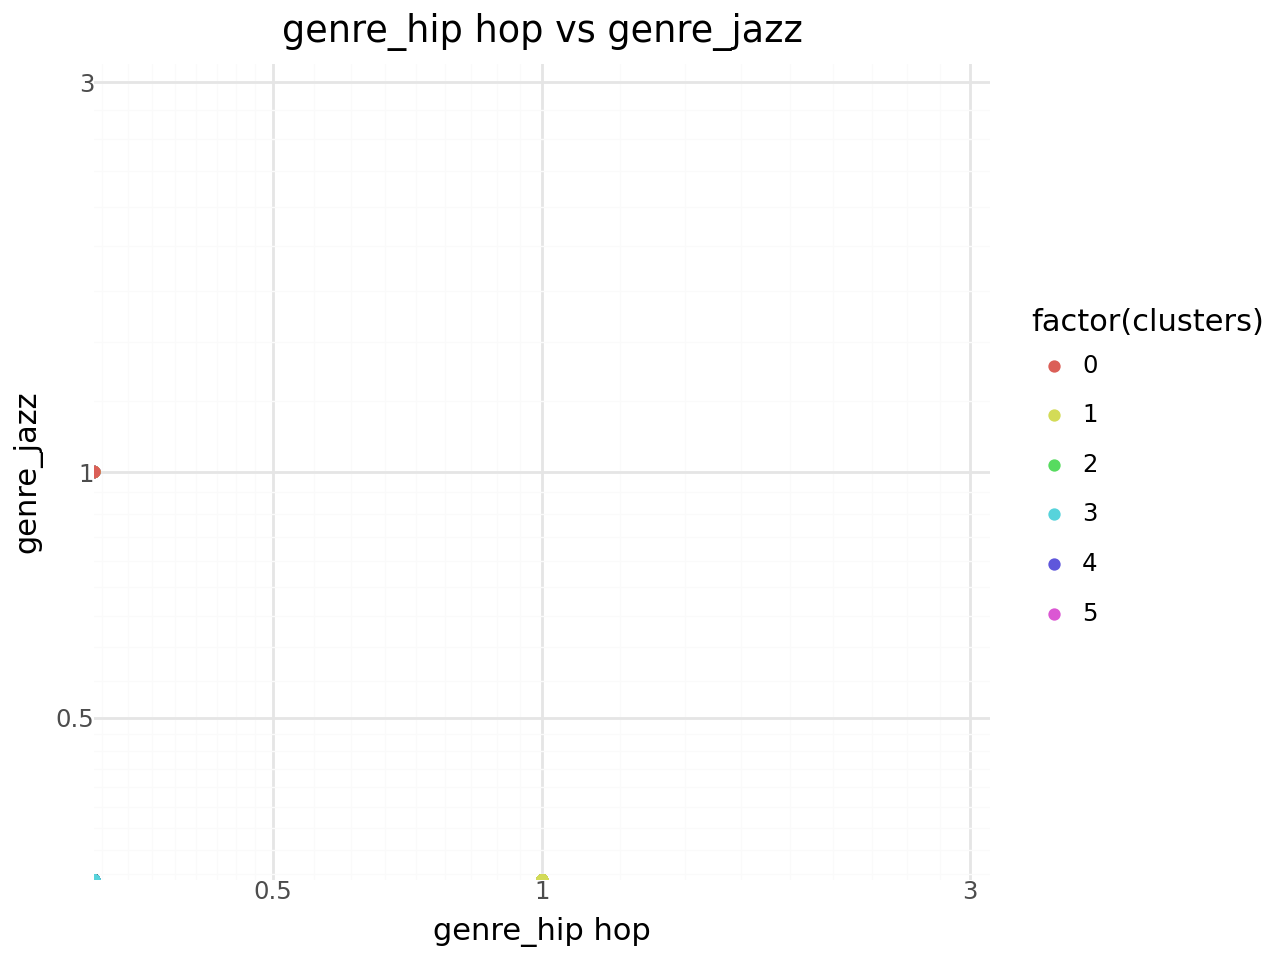

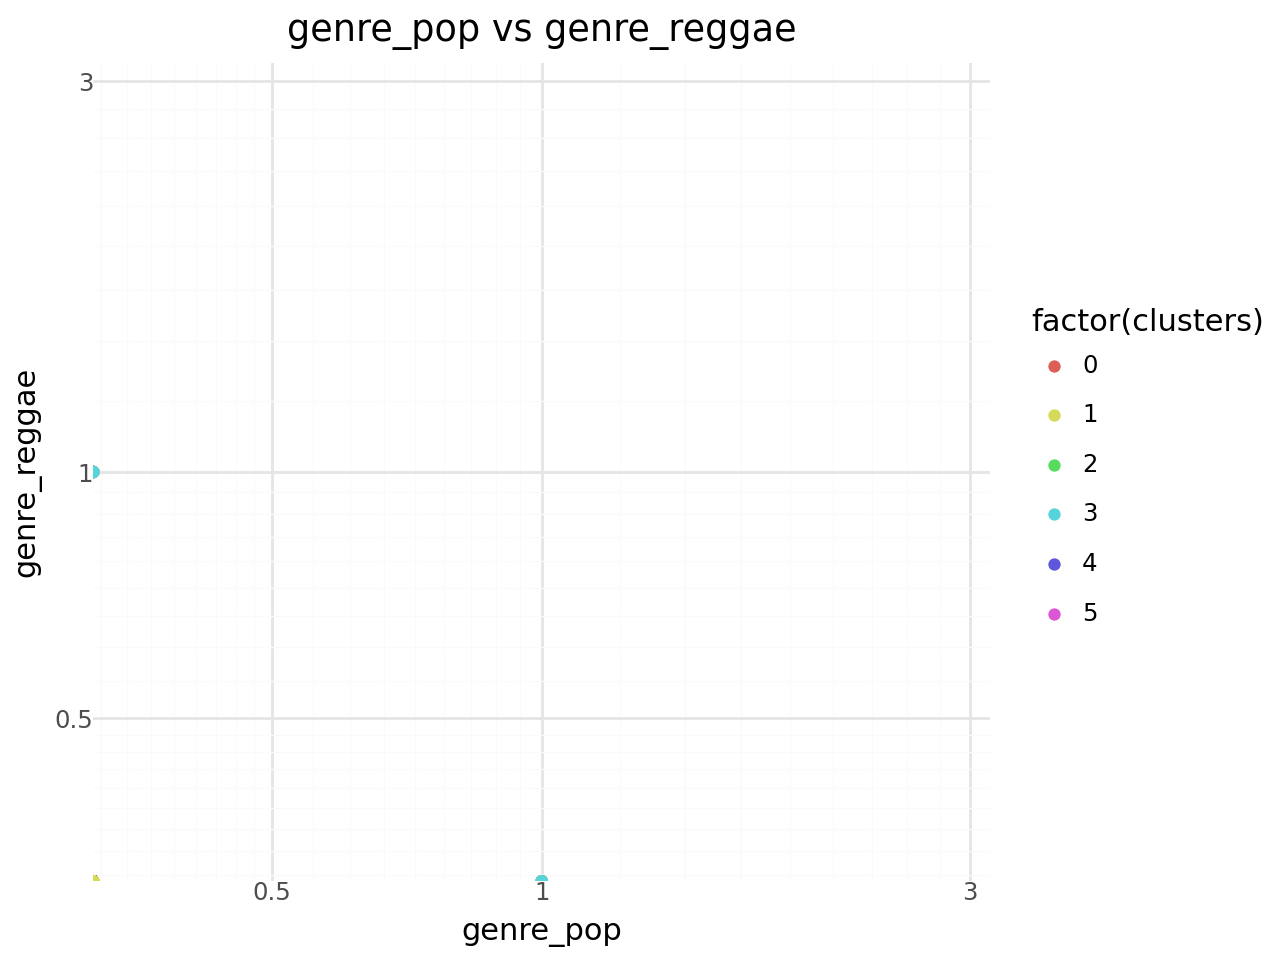

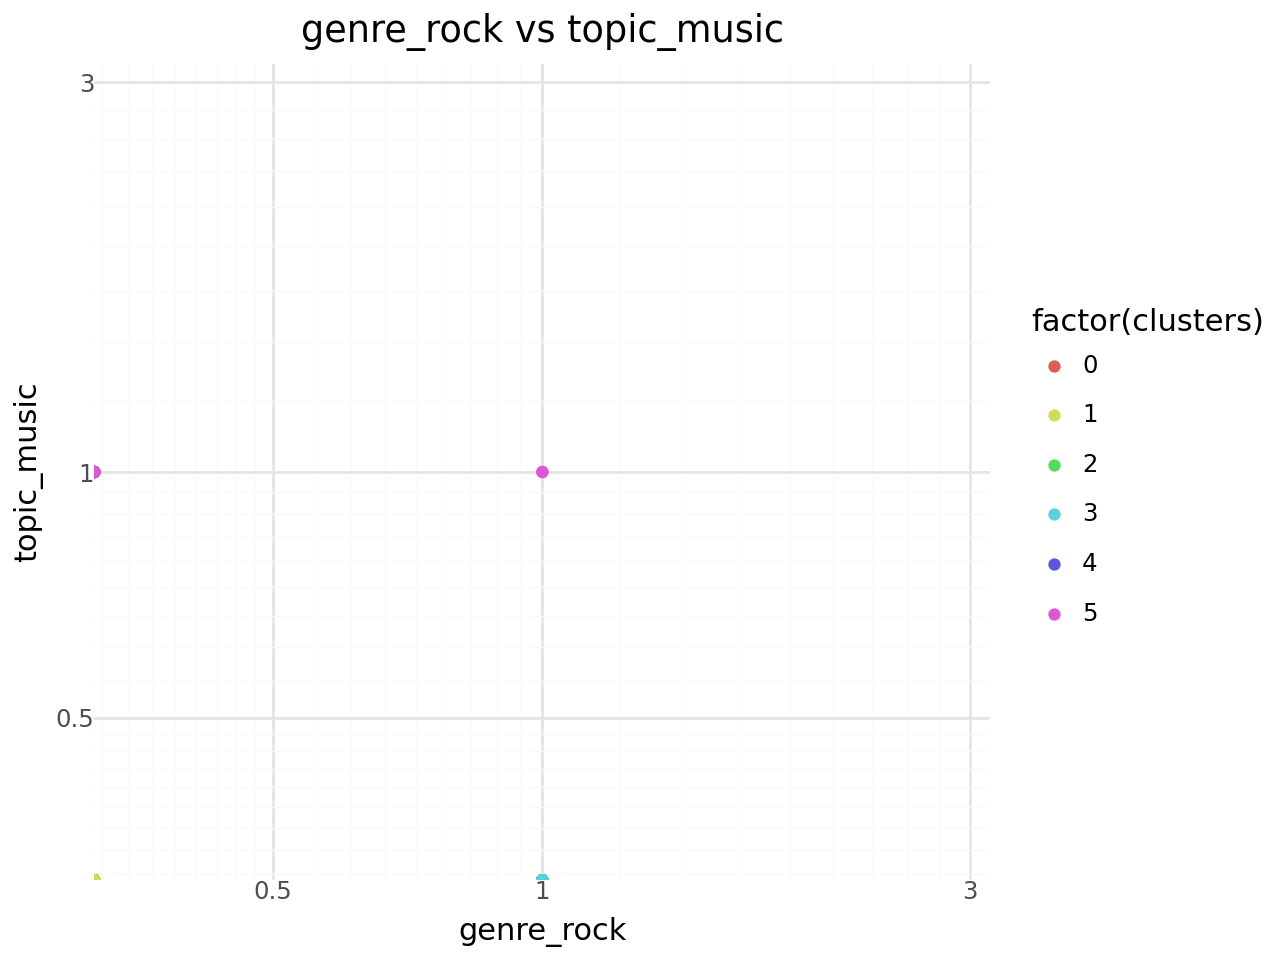

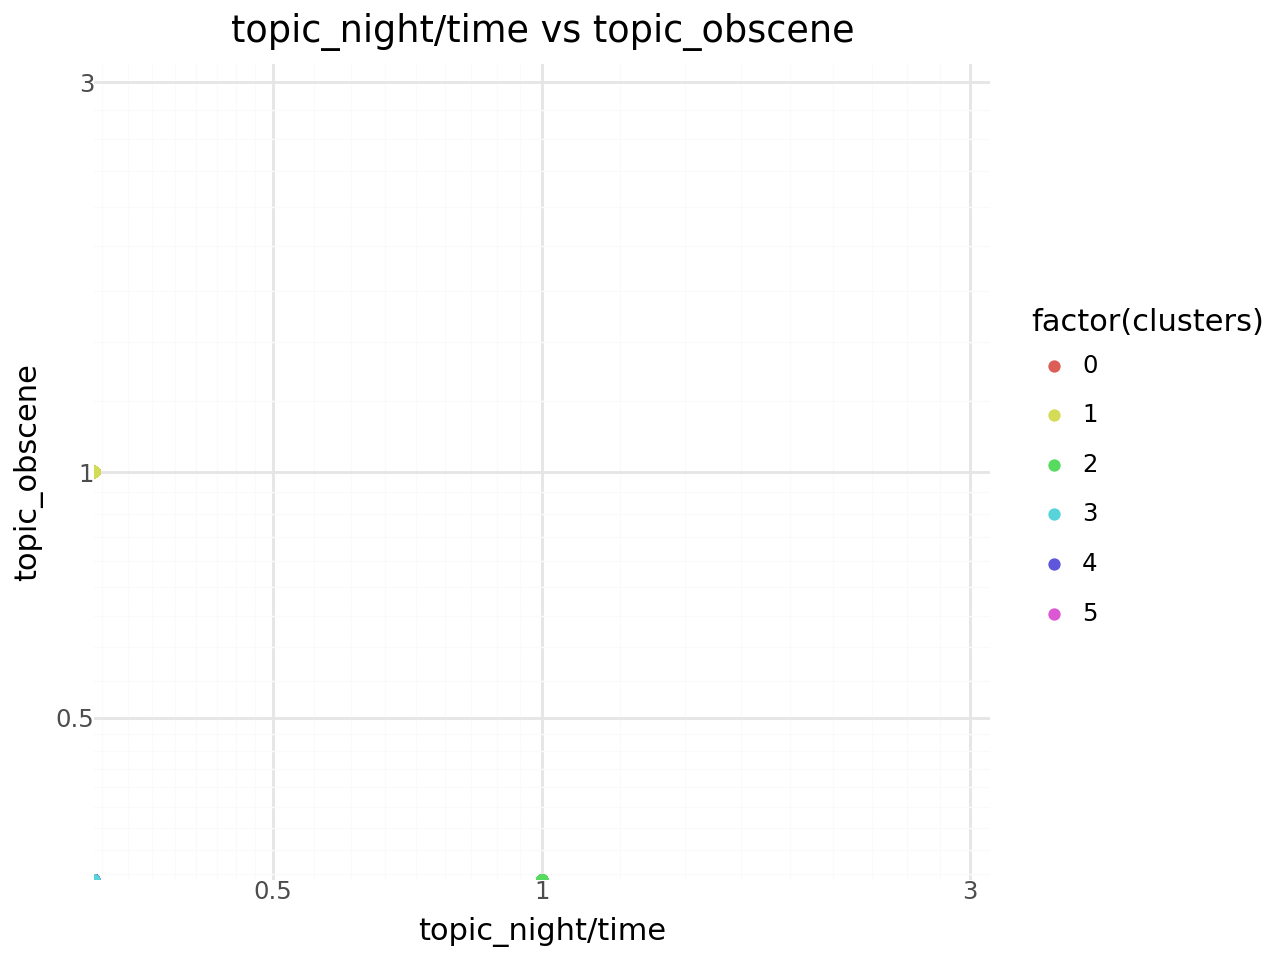

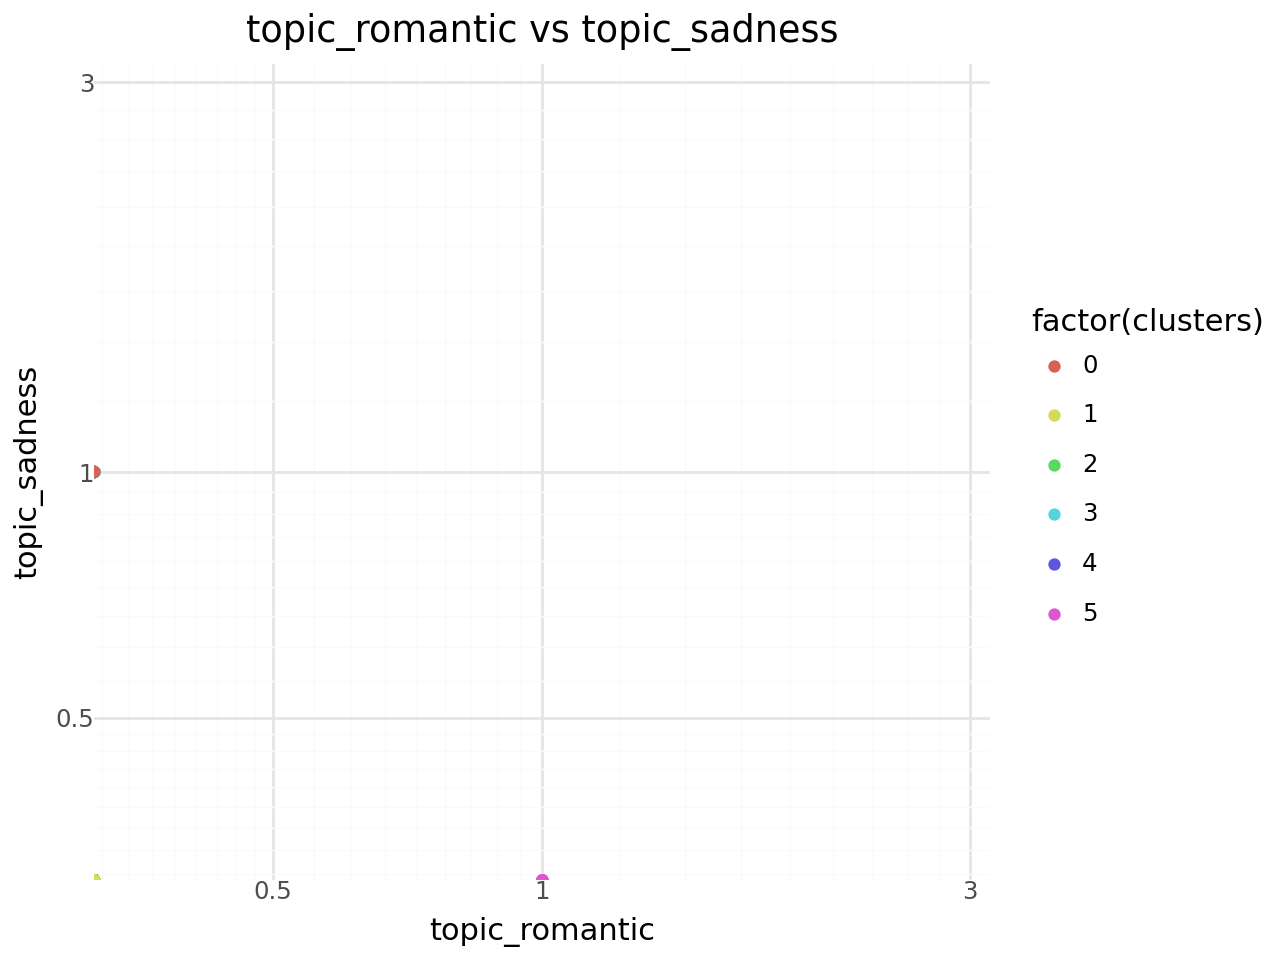

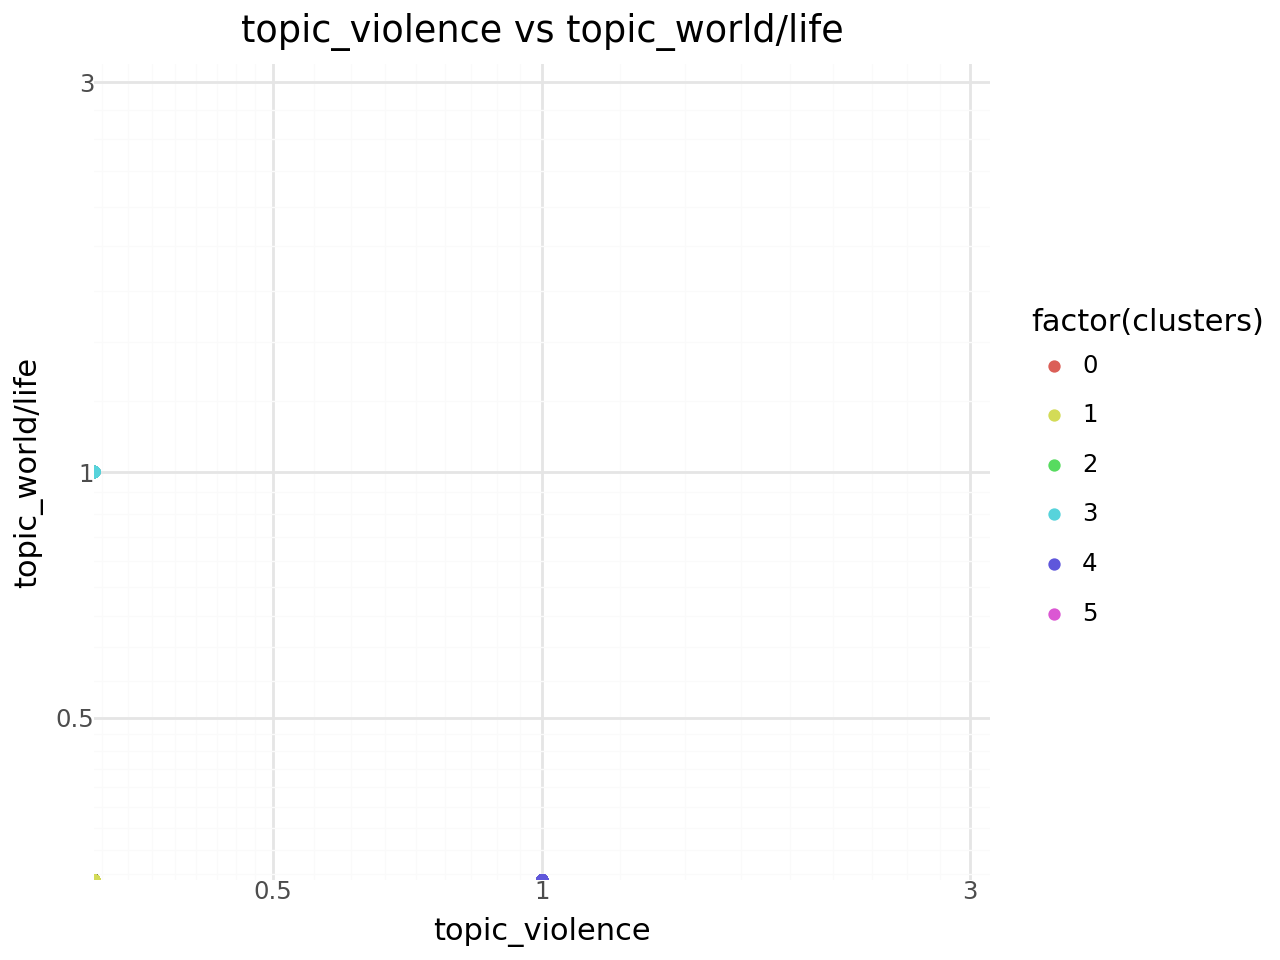

In [ ]:
gmm = GaussianMixture(n_components=6)

# Fit the GMM model and predict clusters
gmm = GaussianMixture(n_components=6)
labels = gmm.fit_predict(X_df)

# Add cluster labels to the clean_data DataFrame
clean_data["clusters"] = labels

# Loop through the list in pairs
for i in range(0, len(columns) - 1, 2):
    col_x = columns[i]
    col_y = columns[i + 1]

    # Create scatterplot with clusters color-coding
    plot = (ggplot(clean_data, aes(x=col_x, y=col_y, color='factor(clusters)')) +
            geom_point() +
            labs(title=f"{col_x} vs {col_y}",
                 x=col_x,
                 y=col_y) +
            scale_x_log10() +  # Log scale for x-axis
            scale_y_log10() +  # Log scale for y-axis
            theme_minimal())

    # Print each plot
    display(plot)

In [ ]:
#Checks data points per cluster

print(clean_data['clusters'].value_counts())

clusters
1    206
3    127
4     92
0     39
5     37
2     30
Name: count, dtype: int64


Cluster
0    27.450980
1    36.166667
2    64.526316
3    24.590426
4    25.142857
5    50.971429
Name: popularity, dtype: float64


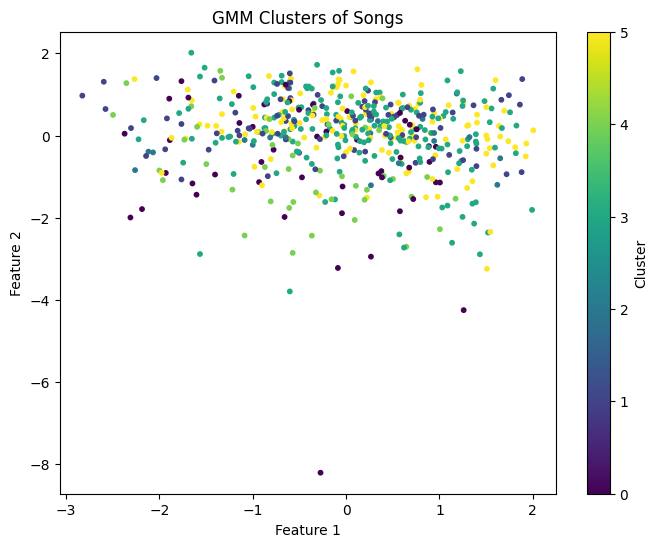

In [ ]:
#Avg Sum Scatterplot with ONLY relevant variables to Further Emphasize Lack of Compatability with Clustering

# Select relevant numerical features for clustering
numerical_features = [
    'danceability', 'loudness', 'acousticness',
    'instrumentalness', 'valence', 'energy', 'streams'
]
X = clean_data[numerical_features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=6, random_state=42)
clusters = gmm.fit_predict(X_scaled)

# Add clusters to the original dataset
clean_data['Cluster'] = clusters

# Analyze cluster means for popularity
cluster_analysis = clean_data.groupby('Cluster')['popularity'].mean()
print(cluster_analysis)

# Plotting clusters for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('GMM Clusters of Songs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Cluster
0    27.450980
1    36.166667
2    64.526316
3    24.590426
4    25.142857
5    50.971429
Name: popularity, dtype: float64


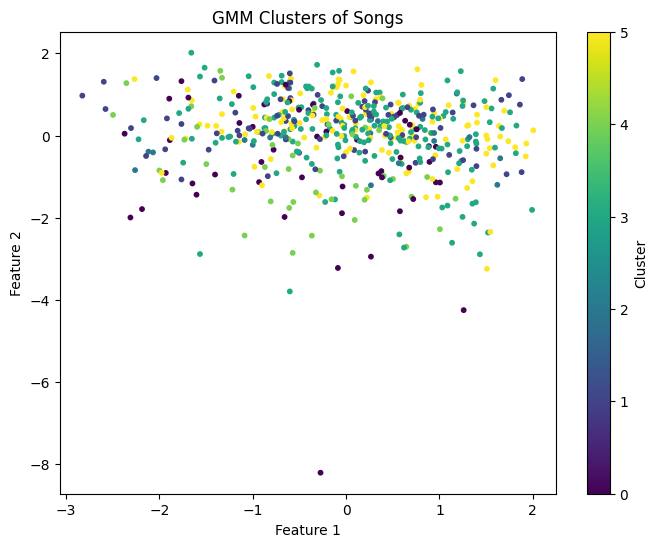

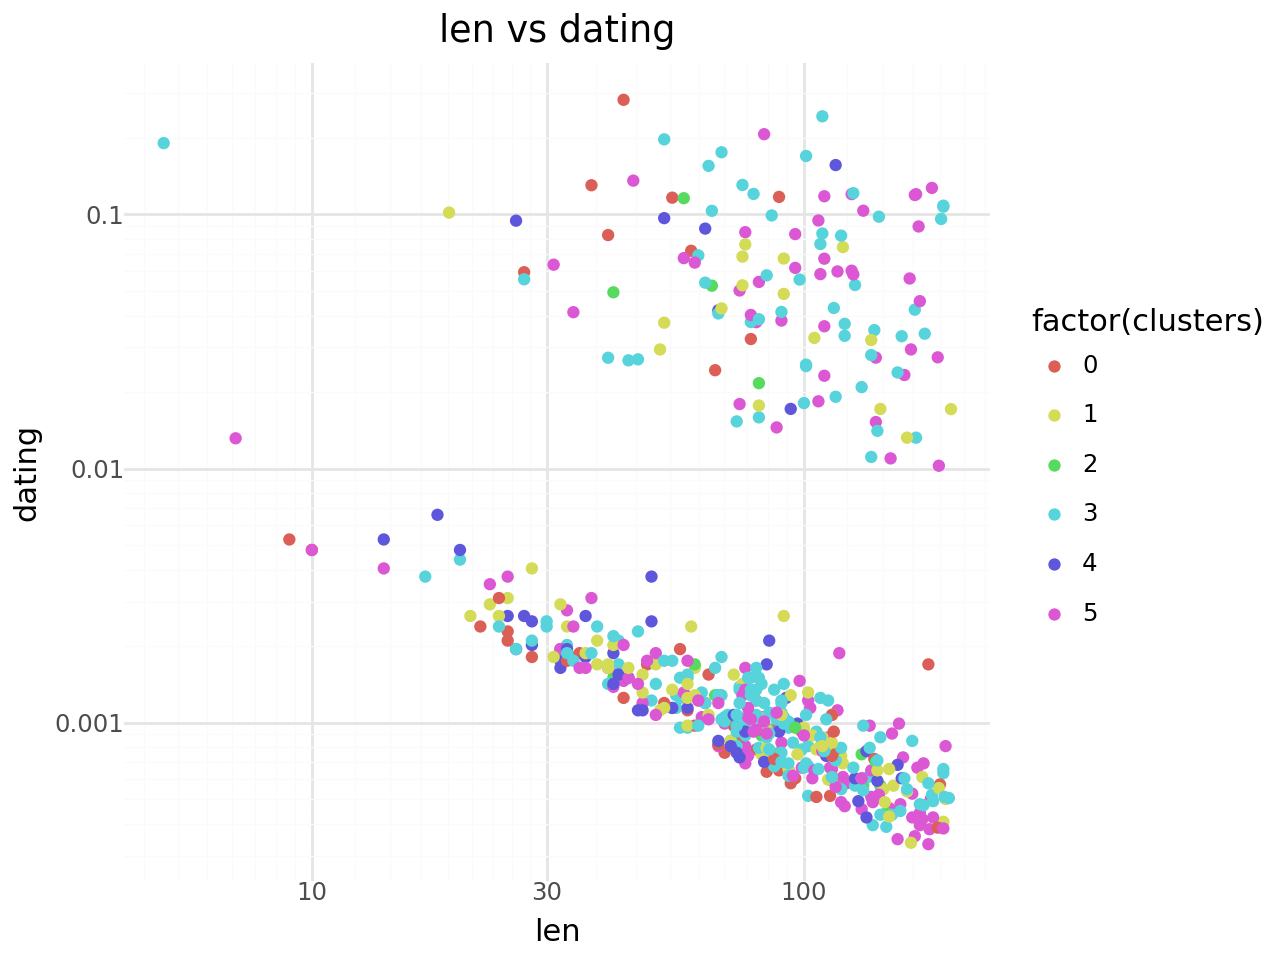

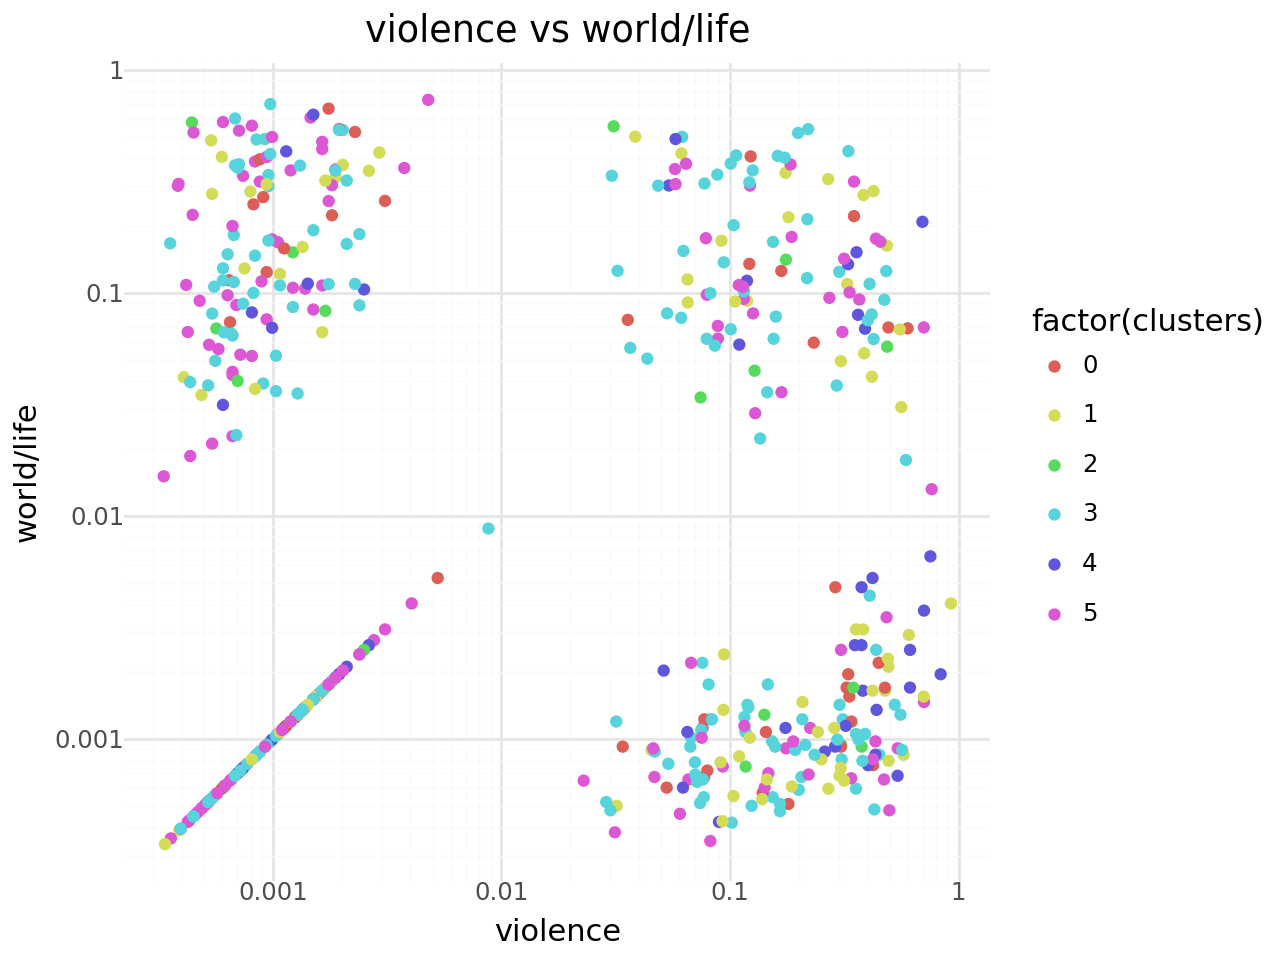

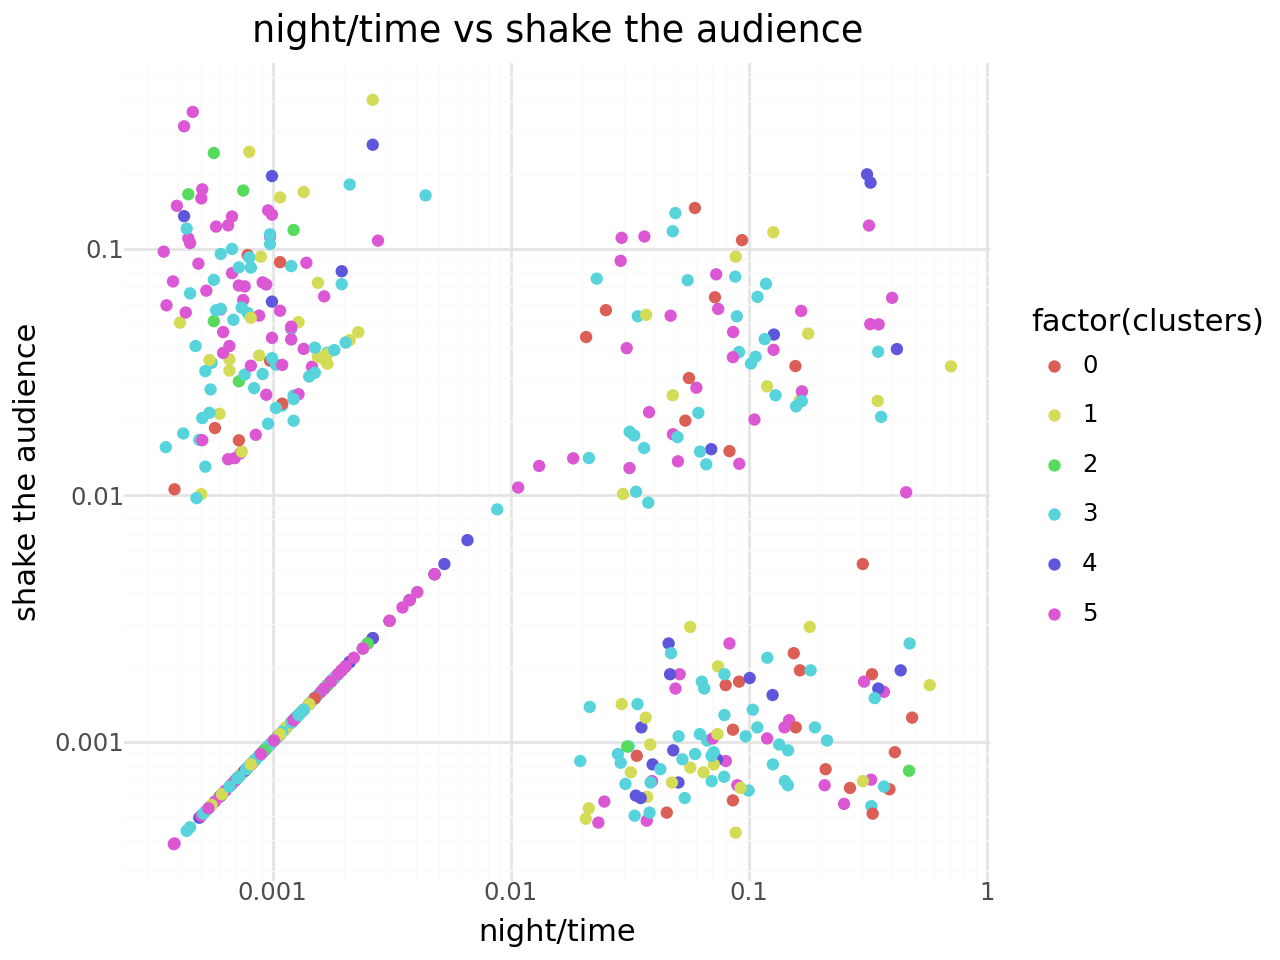

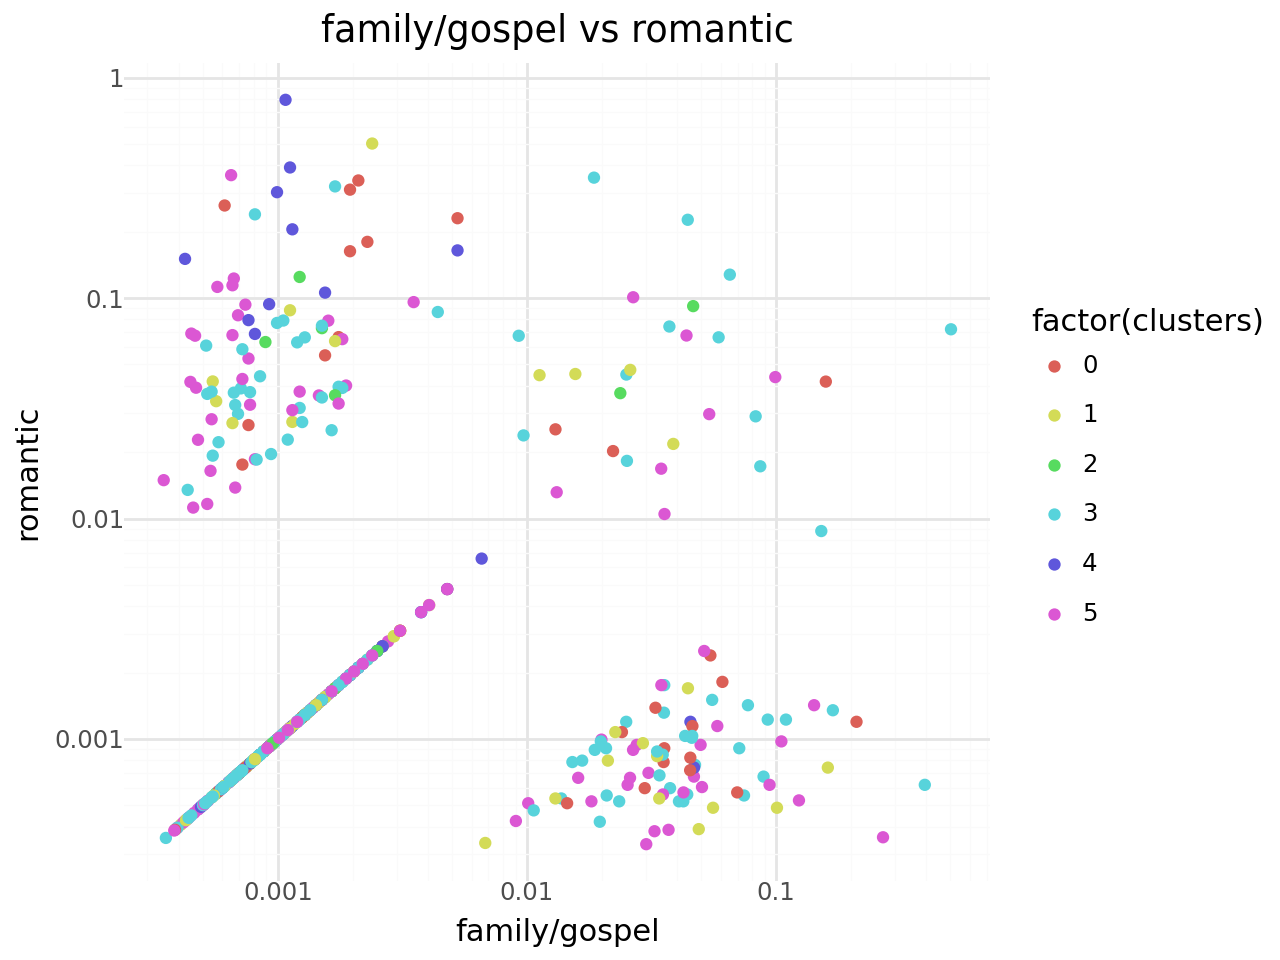

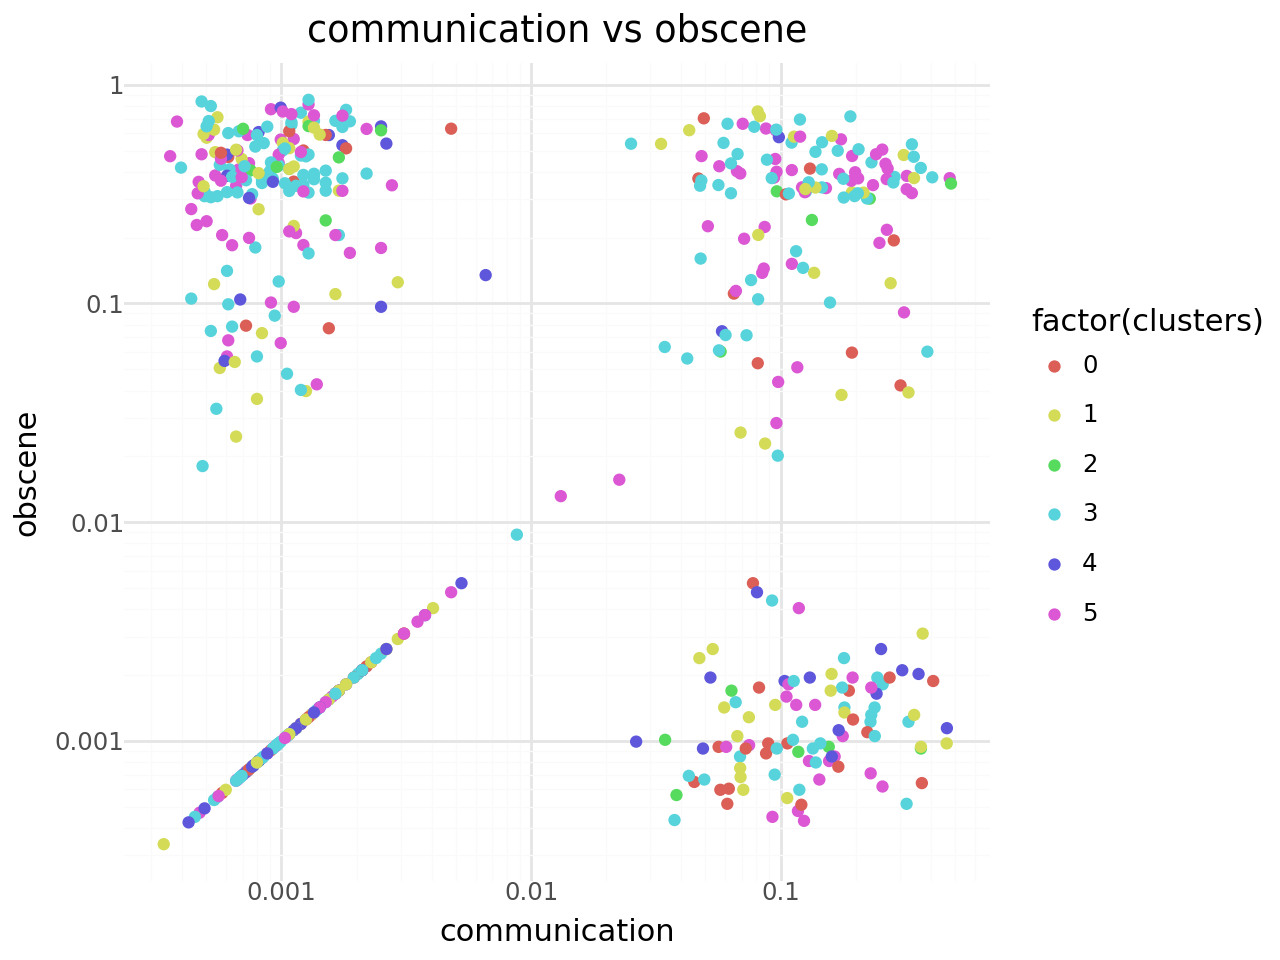

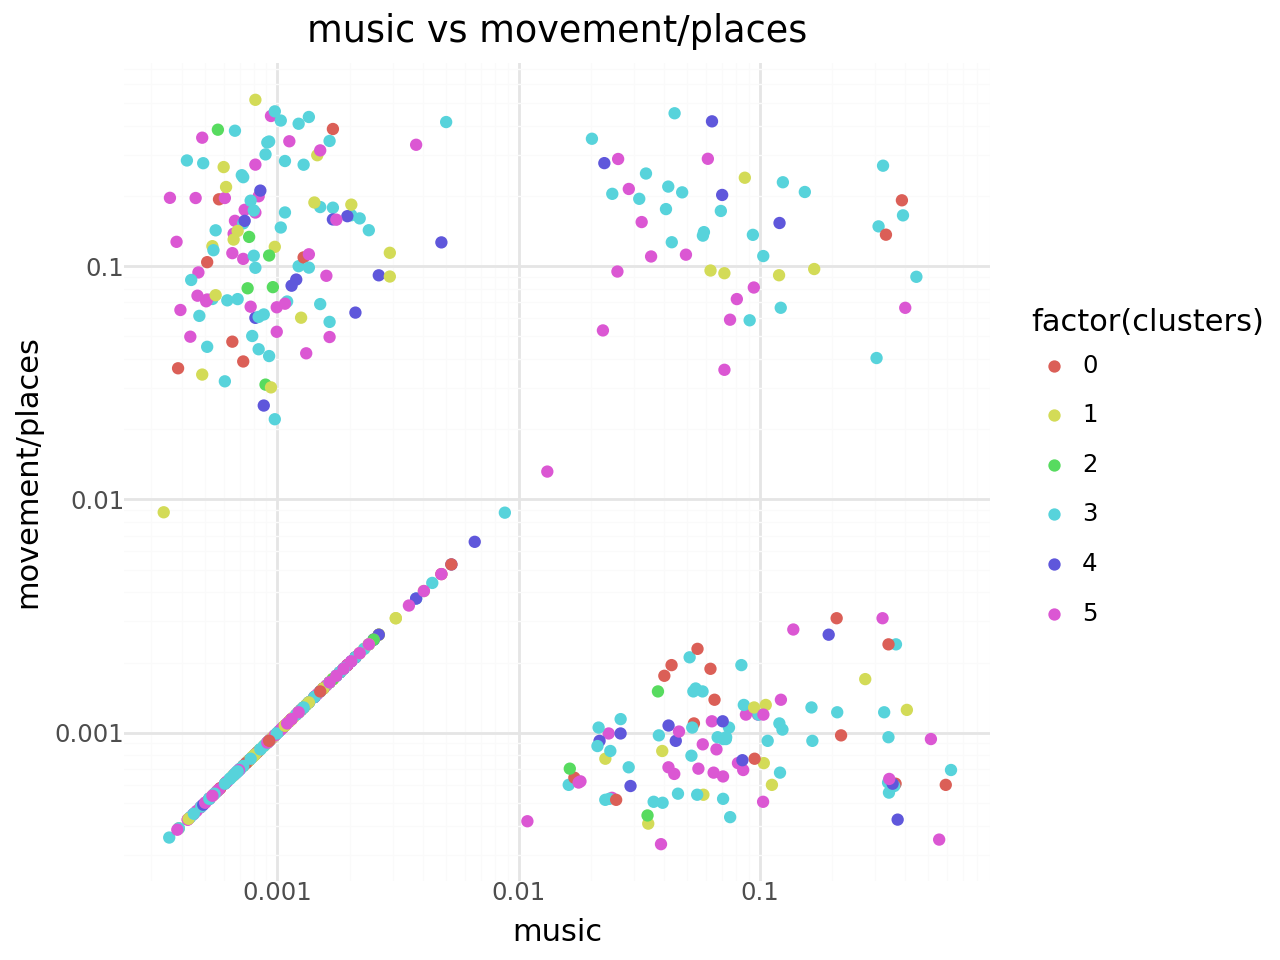

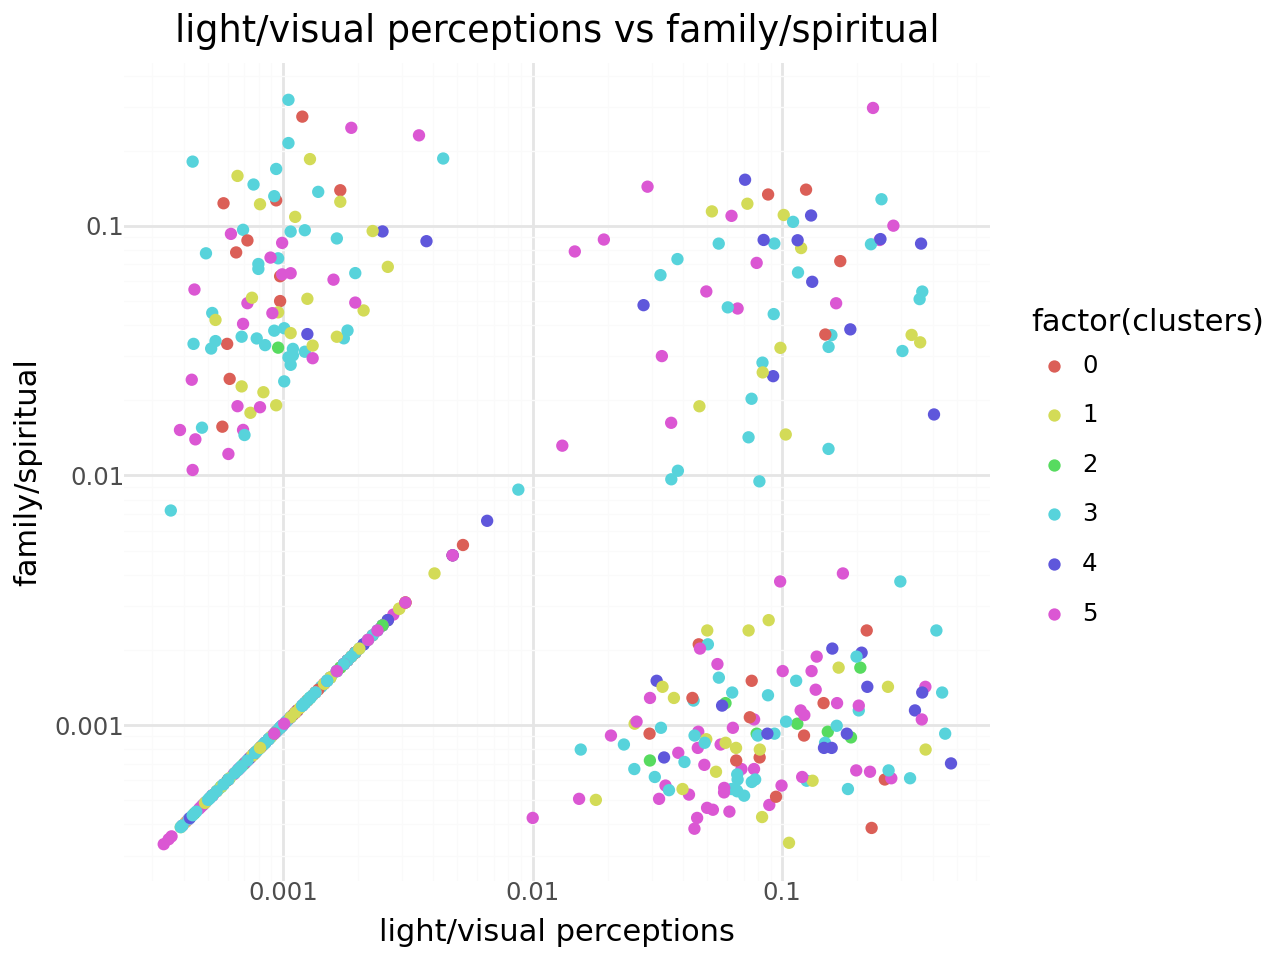

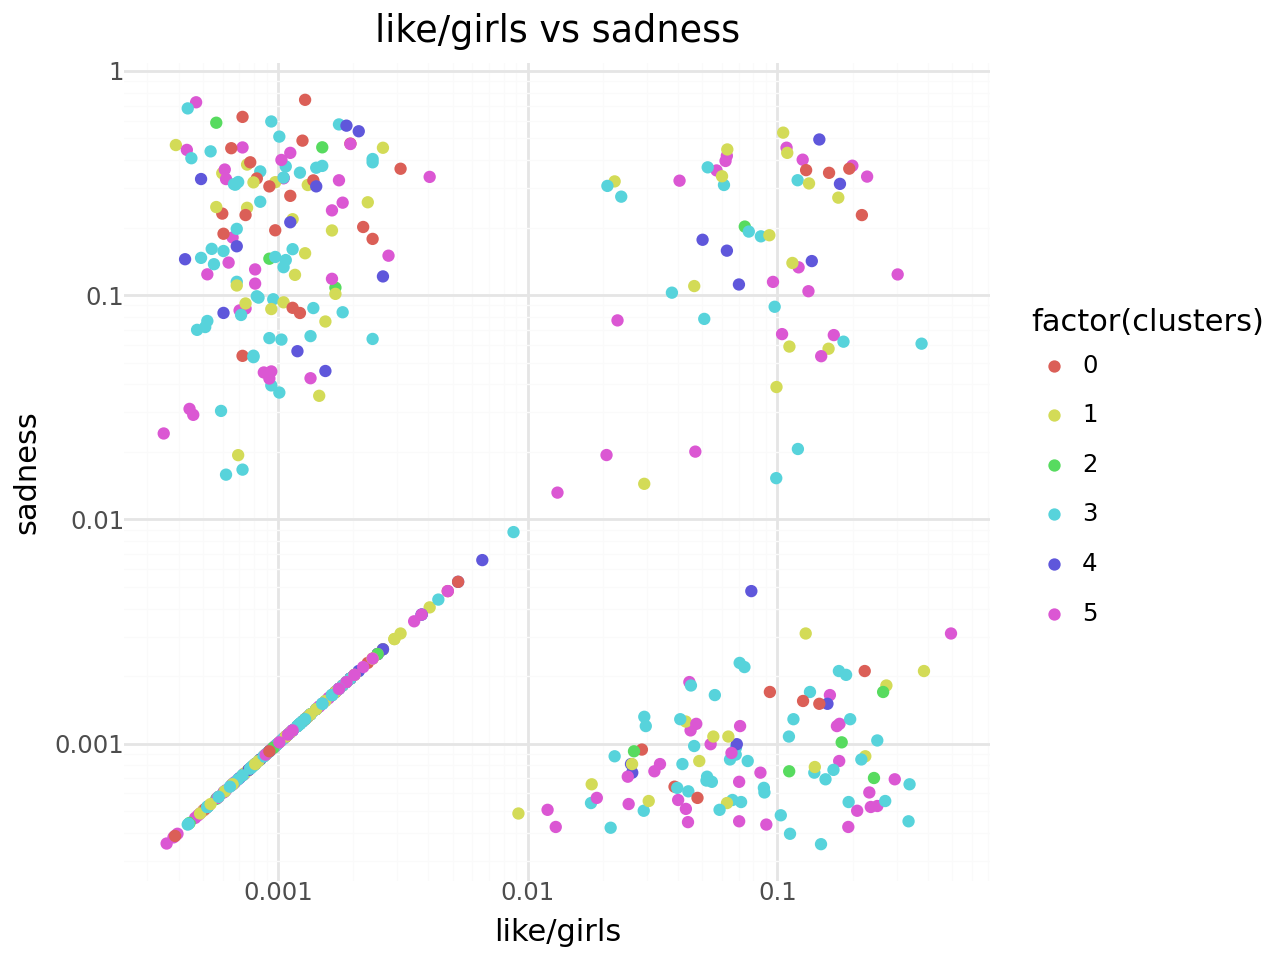

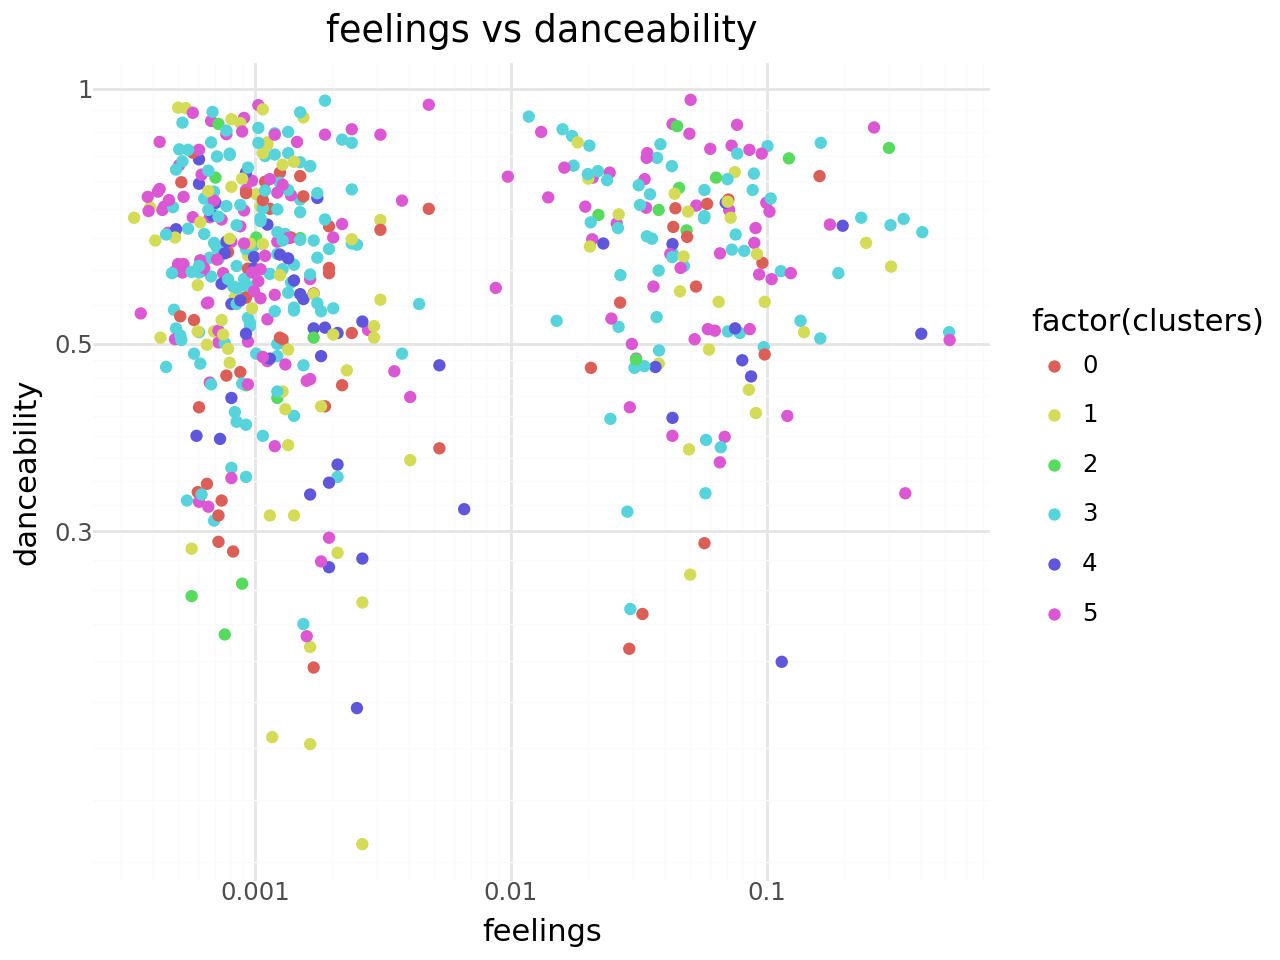

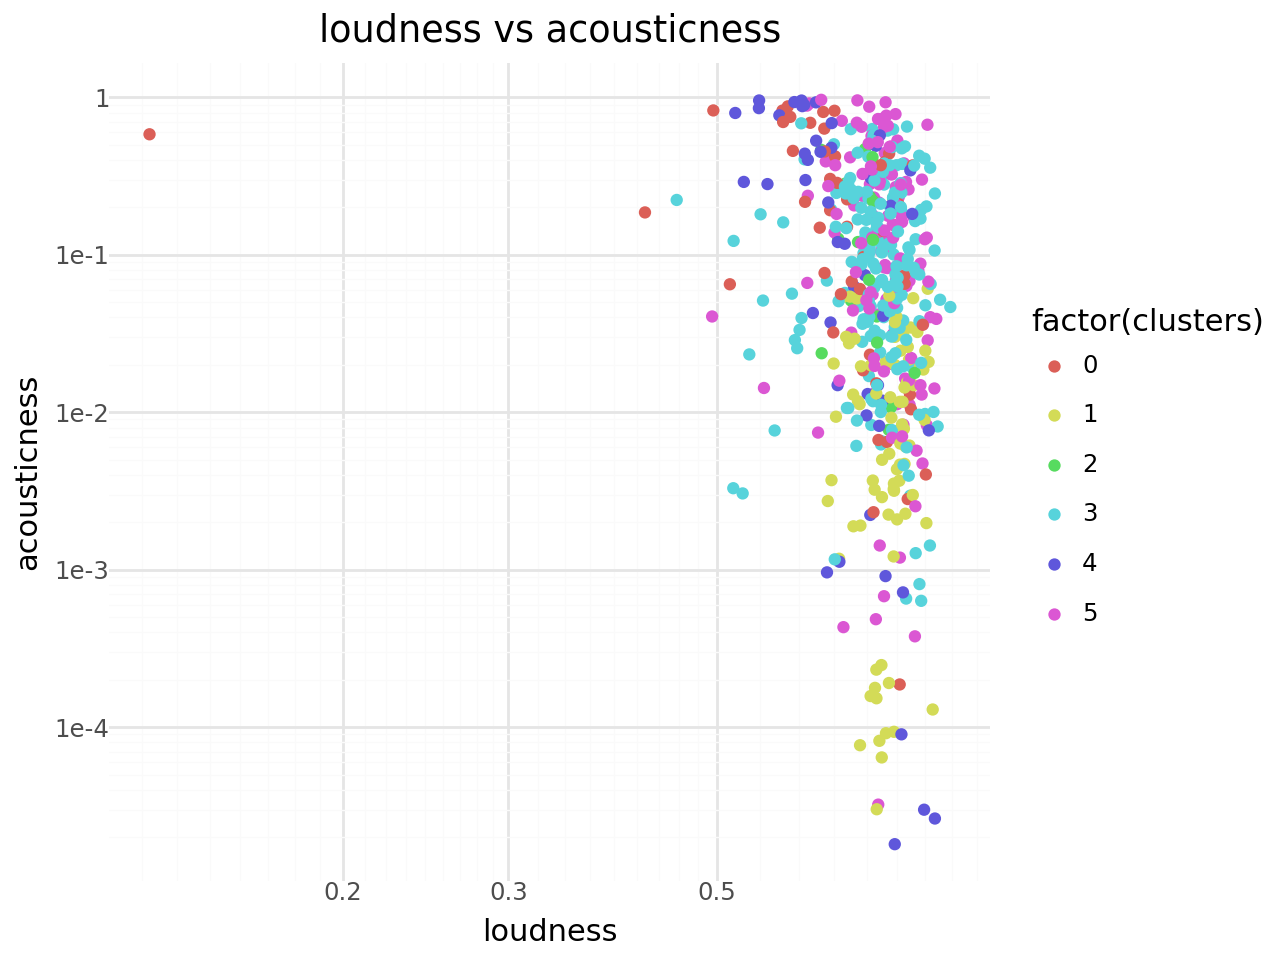

Skipping plot for instrumentalness vs valence due to non-positive values.


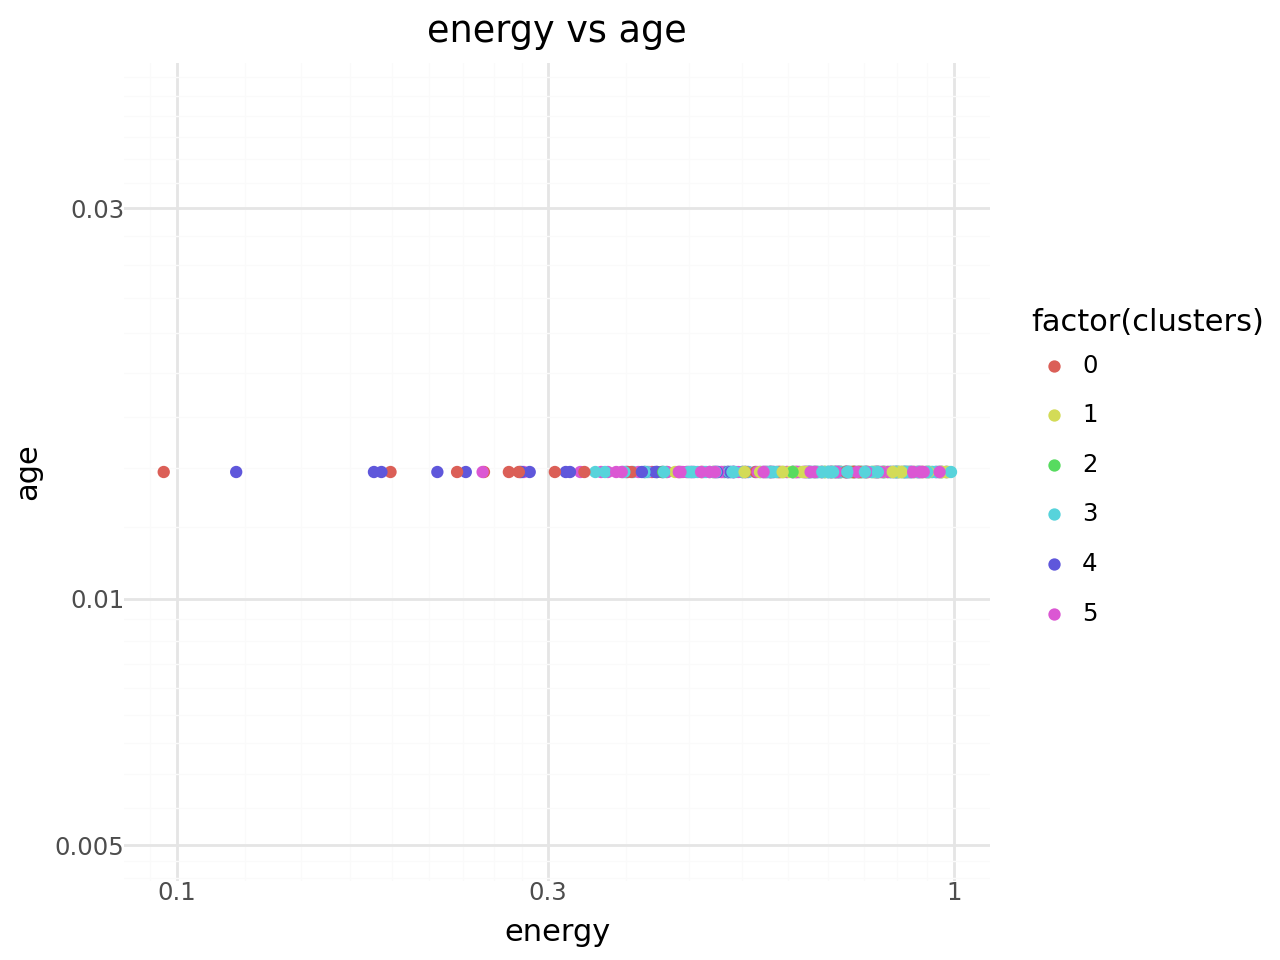

KeyError: 'genre_country'

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select relevant numerical features for clustering
numerical_features = [
    'danceability', 'loudness', 'acousticness',
    'instrumentalness', 'valence', 'energy', 'streams'
]
X = data[numerical_features].dropna()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=6, random_state=42)
clusters = gmm.fit_predict(X_scaled)

# Add clusters to the original dataset
data['Cluster'] = clusters

# Analyze cluster means for popularity
cluster_analysis = data.groupby('Cluster')['popularity'].mean()
print(cluster_analysis)

# Plotting clusters for visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('GMM Clusters of Songs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()


for i in range(0, len(columns) - 1, 2):
    col_x = columns[i]
    col_y = columns[i + 1]

    # Skip if either column contains categorical data or invalid values for log scale
    if data[col_x].dtype == 'object' or data[col_y].dtype == 'object':
        print(f"Skipping plot for {col_x} vs {col_y} due to categorical data.")
        continue

    if (data[col_x] <= 0).any() or (data[col_y] <= 0).any():
        print(f"Skipping plot for {col_x} vs {col_y} due to non-positive values.")
        continue

    # Create the scatterplot using ggplot with color based on clusters
    plot = (ggplot(data, aes(x=col_x, y=col_y, color='factor(clusters)')) +
            geom_point() +
            labs(title=f"{col_x} vs {col_y}",
                 x=col_x,
                 y=col_y) +
            scale_x_log10() +  # Log scale for x-axis
            scale_y_log10() +  # Log scale for y-axis
            theme_minimal())

    # Print each plot
    display(plot)

In [ ]:
log_like_gmm = (gmm.score(X_df))

print(f"Log-likelihood of GMM: {log_like_gmm}")

#Low value indicates it did not perform well

Other Clustering Methods (DBSCAN + KMEANS)

In [ ]:
#DBSCAN


predictors = ['genre', 'len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience',
           'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places',
           'light/visual perceptions', 'family/spiritual', 'like/girls', 'sadness', 'feelings',
           'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
           'topic', 'age', 'popularity', 'streams']

contin = ['len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience',
           'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places',
           'light/visual perceptions', 'family/spiritual', 'like/girls', 'sadness', 'feelings',
           'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
            'age', 'popularity', 'streams']


X = data[predictors]

#Z-Score and OneHotEncode through Pipeline (faster than above, serves same purpose)
z = make_column_transformer((StandardScaler(), contin),
                            (OneHotEncoder(), ["genre", "topic"]),
                            remainder = "passthrough")

db = DBSCAN(eps = 0.25, min_samples = 15)
pipe = Pipeline([("z", z), ("clust", db)])

labels = pipe.fit_predict(X)

X["clusters"] = labels

X_transformed = pipe.named_steps["z"].transform(X)


# Check number of clusters
unique_clusters = X["clusters"].nunique()
print("Unique Clusters:", unique_clusters)

# Compute Silhouette Score only if there are at least 2 clusters
if unique_clusters > 1:
    # Exclude noise points (-1) for Silhouette Score
    valid_clusters = X.loc[X["clusters"] >= 0]
    print(
        "Silhouette Score (valid clusters only):",
        silhouette_score(X_transformed[valid_clusters.index], valid_clusters["clusters"]),
    )
else:
    print("DBSCAN resulted in only 1 cluster. Silhouette Score cannot be computed.")

In [ ]:
#KMEANS

metrics = {"sil": [], "k": []}

for i in range(2,50):
    km = KMeans(i)
    labels = km.fit_predict(X_df)
    sil = silhouette_score(X_df, labels)

    metrics["sil"].append(sil)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

(ggplot(df, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

Clustering with Alt Cleaned Data (Initial Code Used in Presentation)

In [ ]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/kavinravi/MGSC310/refs/heads/main/songs_2019_with_popularity_and_streams%20(1).csv'

data = pd.read_csv(file_path)

data.isnull().sum()

#Popularity and Streams missing values

# Drop unnecessary columns
drop_columns = ["Unnamed: 0", "artist_name", "track_name", "release_date", "lyrics"]
data = data.drop(columns=drop_columns)

# Drop rows with missing values in the target column
data = data.dropna(subset=["popularity"]).reset_index(drop=True)

#Pre-Processing

# Separate features and target
target_column = "popularity"
X = data.drop(columns=[target_column])
y = data[target_column]

# Identify categorical and numerical columns
categorical_columns = ["genre", "topic"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

# OneHotEncode categorical columns and scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(drop="first"), categorical_columns)
    ]
)

# Transform features
X_processed = preprocessor.fit_transform(X)

In [ ]:
#Make ggplot scatterplots of pairs of  features to give  a little bit of information about the data, and to help  decide which
#algorithm to use, these exclude categorical data

from plotnine import ggplot, aes, geom_point, labs, scale_x_log10, scale_y_log10, theme_minimal

columns = ['genre', 'len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience',
           'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places',
           'light/visual perceptions', 'family/spiritual', 'like/girls', 'sadness', 'feelings',
           'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
           'topic', 'age', 'streams'] #excluding target

for i in range(0, len(columns) - 1, 2):
    col_x = columns[i]
    col_y = columns[i + 1]

    # Code to skip if either column contains categorical data or invalid values for log scale
    if data[col_x].dtype == 'object' or data[col_y].dtype == 'object':
        print(f"Skipping plot for {col_x} vs {col_y} due to categorical data.")
        continue

    if (data[col_x] <= 0).any() or (data[col_y] <= 0).any():
        print(f"Skipping plot for {col_x} vs {col_y} due to non-positive values.")
        continue

    plot = (ggplot(data, aes(x=col_x, y=col_y)) +
            geom_point() +
            labs(title=f"{col_x} vs {col_y}",
                 x=col_x,
                 y=col_y) +
            scale_x_log10() +  # Log scale for x-axis
            scale_y_log10() +  # Log scale for y-axis
            theme_minimal())

    # Print each plot
    display(plot)

In [ ]:
#GMM

gmm = GaussianMixture(n_components=6)

# Fit model + predict
labels = gmm.fit_predict(X_processed)

# Add cluster labels to the original DataFrame
data["clusters"] = labels

for i in range(0, len(columns) - 1, 2):
    col_x = columns[i]
    col_y = columns[i + 1]

    # Skip if either column contains categorical data or invalid values for log scale
    if data[col_x].dtype == 'object' or data[col_y].dtype == 'object':
        print(f"Skipping plot for {col_x} vs {col_y} due to categorical data.")
        continue

    if (data[col_x] <= 0).any() or (data[col_y] <= 0).any():
        print(f"Skipping plot for {col_x} vs {col_y} due to non-positive values.")
        continue

    # Create scatterplot
    plot = (ggplot(data, aes(x=col_x, y=col_y, color='factor(clusters)')) +
            geom_point() +
            labs(title=f"{col_x} vs {col_y}",
                 x=col_x,
                 y=col_y) +
            scale_x_log10() +  # Log scale for x-axis
            scale_y_log10() +  # Log scale for y-axis
            theme_minimal())

    # Print each plot
    display(plot)

In [ ]:
log_like_gmm = (gmm.score(X_processed))

print(f"Log-likelihood of GMM: {log_like_gmm}")

#Low value indicates it did not perform well